<a href="https://colab.research.google.com/github/lbk209/topic_modeling/blob/main/tm_develop_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [1]:
%%capture
!pip install bertopic

In [2]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import tqdm
import datetime

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', 5000)

import plotly.io as pio
pio.templates.default = 'simple_white'
from bertopic import BERTopic

# Data

In [3]:
path_src = '/content/drive/MyDrive/Colab\ Notebooks'
path_data = 'sample_data'

In [4]:
file = 'hotel_reviews_with_transl'
!unzip -n {path_src}/{file}.zip -d {path_data}

Archive:  /content/drive/MyDrive/Colab Notebooks/hotel_reviews_with_transl.zip
  inflating: sample_data/hotel_reviews_with_transl.csv  


In [5]:
f = f'{path_data}/{file}.csv'
df_data = pd.read_csv(f, sep = '\t')

In [6]:
df_data.head(1)

,id,hotel,review,lang,reviews_transl,reviews_len
0,0,Travelodge,"A good budget choice but only if you can't afford better!. GOOD POINTS-Cheap (I stayed here for some nights for 20 pounds - this is fantastic for central London)- Family rooms are spacious for 2 people- Restaurants very close eg Nanos (portugese), Strada (Italian), Pasta, fast food at the station etc)- Staff are friendly-Early check in available (but at a cost). Some hotels I have been in do not even allow early check in so I put this as a good point.-Safe area.BAD POINTS-Mattress was uncomfortable - sinks in the middle. My wife had back problems every day (!)-Pillows are thin, hard and uncomfortable. I ended up buying a couple as I was staying for 2 weeks. - Road noise when windows are open is load but okay when windows are closed-Air -conditioning does not work in any room I have been in (I have tried 5 rooms). Windows open with a key that is available at reception though.-Towels aren't very good and often you have to ask for more.-Double rooms felt claustrophobic!",en,"A good budget choice but only if you can't afford better!. GOOD POINTS-Cheap (I stayed here for some nights for 20 pounds - this is fantastic for central London)- Family rooms are spacious for 2 people- Restaurants very close eg Nanos (portugese), Strada (Italian), Pasta, fast food at the station etc)- Staff are friendly-Early check in available (but at a cost). Some hotels I have been in do not even allow early check in so I put this as a good point.-Safe area.BAD POINTS-Mattress was uncomfortable - sinks in the middle. My wife had back problems every day (!)-Pillows are thin, hard and uncomfortable. I ended up buying a couple as I was staying for 2 weeks. - Road noise when windows are open is load but okay when windows are closed-Air -conditioning does not work in any room I have been in (I have tried 5 rooms). Windows open with a key that is available at reception though.-Towels aren't very good and often you have to ask for more.-Double rooms felt claustrophobic!",981


In [7]:
df_data.review.count()

12296

In [8]:
# testing
df_data = df_data.sample(frac=.2)
df_data = df_data.drop('id', axis=1).reset_index(drop=True).rename_axis('id').reset_index()
df_data.head(1)

,id,hotel,review,lang,reviews_transl,reviews_len
0,0,Holiday Inn,Excellent hotel -. We stayed at this hotel for a weekend away. We stay in London alot and this has to be our favourite so far. It is lovely and clean. The staff are helpful in the bar &amp; restaurant. The breakfast buffet is brilliant. The room was a really big and clean. It has great leisure facilities inc a pool - which unfortunately we did not get time to use.The only downside is that the tube station is a 15 minute walk which if you have heavy cases is a pain. So just get a taxi. We alos ended up getting a taxi to the centre for about £15.We will definatley stay again. Oh and we found much cheaper offers direct on the hotel website.,en,Excellent hotel -. We stayed at this hotel for a weekend away. We stay in London alot and this has to be our favourite so far. It is lovely and clean. The staff are helpful in the bar &amp; restaurant. The breakfast buffet is brilliant. The room was a really big and clean. It has great leisure facilities inc a pool - which unfortunately we did not get time to use.The only downside is that the tube station is a 15 minute walk which if you have heavy cases is a pain. So just get a taxi. We alos ended up getting a taxi to the centre for about £15.We will definatley stay again. Oh and we found much cheaper offers direct on the hotel website.,645


In [9]:
df_data.review.count()

2459

In [10]:
docs = df_data.reviews_transl.tolist()
classes_all = df_data.hotel.tolist()

# 🗨️ **BERTopic**

In [11]:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Name', 'Representation'] + extra_cols]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]

representation_model = {
   "Main": main_representation_model,
   "Aspect1":  aspect_representation_model1,
   "Aspect2":  aspect_representation_model2
}

vectorizer_model = CountVectorizer(
    min_df=5,
    stop_words = 'english')
topic_model = BERTopic(
    min_topic_size = 5, # default 10
    nr_topics = 'auto',
    vectorizer_model = vectorizer_model,
    representation_model = representation_model)
topics, ini_probs = topic_model.fit_transform(docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
num_topics = len(topic_model.get_topics()) - 1
num_topics

57

In [ ]:
get_topic_stats(topic_model, ['Aspect1', 'Aspect2']).head(7).set_index('Topic')

,Count,Share,CumulativeShare,Name,Representation,Aspect1,Aspect2
Topic,,,,,,,
-1,1072,43.59,43.59,-1_hotel_hotels_london_rooms,"[hotel, hotels, london, rooms, room, hilton, booked, place, restaurant, reception]","[hotel, room, good, staff, breakfast, location, stay, night, rooms, great]","[hotels, london, room, booked, restaurant, reception, bus, reviews, bar, stayed]"
0,990,40.26,83.86,0_hotel_hotels_rooms_london,"[hotel, hotels, rooms, london, room, inn, spacious, hilton, heathrow, bathroom]","[hotel, room, london, great, location, good, stay, breakfast, clean, staff]","[hotels, rooms, heathrow, bathroom, place, booked, gloucester, victoria, reception, central]"
1,30,1.22,85.08,1_hotel_euston_rooms_hilton,"[hotel, euston, rooms, hilton, london, cafe, station, room, reception, travelodge]","[station, hotel, minutes, nice, good, breakfast, room, size, staff, rooms]","[hotel, euston, rooms, london, cafe, station, bathroom, reviews, st, store]"
2,25,1.02,86.09,2_hilton_hotel_hotels_lounge,"[hilton, hotel, hotels, lounge, room, queue, queues, booked, pool, staying]","[hilton, executive, room, lounge, staff, line, standards, hotel, floor, pool]","[hotels, queue, pool, station, paddington, drinks, fridge, clerk, points, minutes]"
3,25,1.02,87.11,3_hotel_hotels_london_rooms,"[hotel, hotels, london, rooms, inn, booking, bloomsbury, covent, booked, room]","[hotel, good, breakfast, nice, clean, great, room, trip, location, staff]","[hotels, london, bloomsbury, booked, room, bath, theatre, recommend, museum, holborn]"
4,19,0.77,87.88,4_rooms_hotel_london_room,"[rooms, hotel, london, room, furnished, gloucester, tours, kensington, concierge, fixtures]","[road, location, street, room, grocery, desk, helpful, hotel, lines, station]","[rooms, hotel, london, furnished, tours, bath, restaurants, definitely, carpets, station]"
5,19,0.77,88.65,5_hotel_booking_rooms_facilities,"[hotel, booking, rooms, facilities, booked, london, concert, room, station, park]","[concert, hotel, stay, bathroom, lovely, basic, walk, facilities, station, clean]","[hotel, facilities, london, concert, station, park, taxi, access, shuttle, dlr]"


In [ ]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [ ]:
topic_model.visualize_topics()

In [ ]:
df_data['basic_topic'] = topics

# Topic distribution

In [ ]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, window = 4,
                                                                      calculate_tokens=True)

In [ ]:
topic_distr.shape

(6148, 48)

In [ ]:
topic_distr

array([[0.06371714, 0.06873226, 0.0132352 , ..., 0.00121798, 0.005349  ,
        0.03482469],
       [0.05241437, 0.04816061, 0.0202135 , ..., 0.06517852, 0.01004273,
        0.01279541],
       [0.05224263, 0.0837024 , 0.01374098, ..., 0.        , 0.00382569,
        0.04156356],
       ...,
       [0.05090641, 0.04772442, 0.01767312, ..., 0.        , 0.        ,
        0.06165296],
       [0.04443437, 0.05440567, 0.02188142, ..., 0.00669112, 0.00992321,
        0.01245146],
       [0.05238923, 0.05312501, 0.09075179, ..., 0.00346122, 0.00794154,
        0.00982997]])

Text(0.5, 1.0, 'Distribution of topic non-zero probabilities')

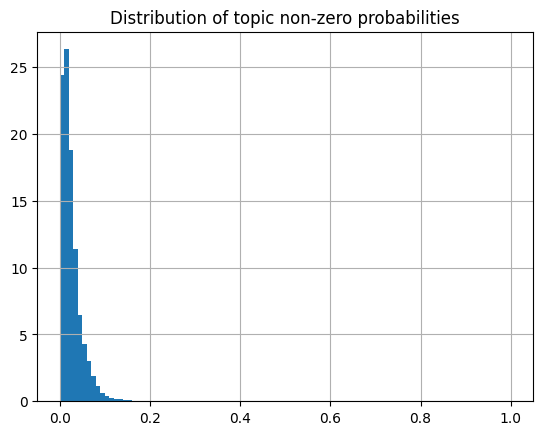

In [ ]:
raw_distr = pd.Series(topic_distr.ravel())
raw_distr = raw_distr[raw_distr > 0]

ax = raw_distr.hist(bins = 100, range = [0, 1],
                                        weights = np.ones_like(raw_distr)*100/raw_distr.shape[0])
ax.set_title('Distribution of topic non-zero probabilities')

In [ ]:
df_data['max_topic_distr'] = topic_distr.max(axis = 1)

In [ ]:
 df_data[df_data.max_topic_distr > 0.05].shape

(6104, 7)

In [ ]:
1 - df_data[df_data.max_topic_distr > 0.05].shape[0]/df_data.shape[0]

0.0071567989590111125

In [ ]:
df_data.head(3)

,hotel,review,lang,reviews_transl,reviews_len,basic_topic,max_topic_distr
0,Hilton,"very convinient location. My room on the 3rd floor was spacious, clean. Lighting was good, both in room and bathroom. Room was a little worn, as some of the wallpaper had marks or was peeling off. The matrasse was not the newest either, fairly cheap quality. In the bathroom the tub was a little mildewy though and smelled -even the next day- of chlorid cleaner. (So is was probably clean, I did not have somebody making up my room due to the Do not Disturb Sign at the door.) The shower curtain was missing the interior part. Spacious bathroom with plenty of space to place bathroom amenities. The room windows open a little, so you do not have to rely on AC, which was working very well (it was set for cooling, which I did not need). The roomwalls were not too thick, I was lucky that my neighbor did not turn on the TV too loudly. Internet access is very expensive with PoundSterling 15,- per 24h. Check-in staff allowed me into the room earlier. Thank you! Breakfast was of intermediate quality, basically nothing special taste-wise, though the staff working there was very friendly, helpful and service-oriented. The same I can say about the check-in and concierge staff. The selling point was for me the easy access from the airport. Heathrow Express brings you from the LHR airport to the hotel located in the Paddington Station within 20minutes. Underneath/next to the hotel is theTube Station of three different subway lines, one of them the Bakerloo Line, that easily brings you within 15 minutes to the West End...The PA system is definately working. I was lucky to experience it, due to the in London not so unusual evacuation alarm going off at one evening. The hotel appears pretty secure due to plenty of CCTV cameras located at all corners of all ceilings, though elevator access is not restricted by room key cards and the street emergency exits did not close either behind me during the evacuation. However, I would stay again, rather have one fake alarm too many than a real fire. During the evacuation I noticed that my room did not have a safety exit map posted on the room's door.",en,"very convinient location. My room on the 3rd floor was spacious, clean. Lighting was good, both in room and bathroom. Room was a little worn, as some of the wallpaper had marks or was peeling off. The matrasse was not the newest either, fairly cheap quality. In the bathroom the tub was a little mildewy though and smelled -even the next day- of chlorid cleaner. (So is was probably clean, I did not have somebody making up my room due to the Do not Disturb Sign at the door.) The shower curtain was missing the interior part. Spacious bathroom with plenty of space to place bathroom amenities. The room windows open a little, so you do not have to rely on AC, which was working very well (it was set for cooling, which I did not need). The roomwalls were not too thick, I was lucky that my neighbor did not turn on the TV too loudly. Internet access is very expensive with PoundSterling 15,- per 24h. Check-in staff allowed me into the room earlier. Thank you! Breakfast was of intermediate quality, basically nothing special taste-wise, though the staff working there was very friendly, helpful and service-oriented. The same I can say about the check-in and concierge staff. The selling point was for me the easy access from the airport. Heathrow Express brings you from the LHR airport to the hotel located in the Paddington Station within 20minutes. Underneath/next to the hotel is theTube Station of three different subway lines, one of them the Bakerloo Line, that easily brings you within 15 minutes to the West End...The PA system is definately working. I was lucky to experience it, due to the in London not so unusual evacuation alarm going off at one evening. The hotel appears pretty secure due to plenty of CCTV cameras located at all corners of all ceilings, though elevator access is not res

In [ ]:
df_data[(df_data.max_topic_distr > 0.1) & (df_data.reviews_len >= 100)].sample(10)

,hotel,review,lang,reviews_transl,reviews_len,basic_topic,max_topic_distr
6117,Radisson,Above average for London. I just recently stayed at the Portman Square and it was nice. The price was average especially when prices are outrageous now. The roomsize was small but I mean you can't expect much in London honestly. Rooms are always going to be small and these were decent size. The bathrooms were the best part because there were American Standard bathrooms. There is great shopping two blocks down on Oxford Street but you must eat/drink early because that area closes by 10pm! Cheerio!,en,Above average for London. I just recently stayed at the Portman Square and it was nice. The price was average especially when prices are outrageous now. The roomsize was small but I mean you can't expect much in London honestly. Rooms are always going to be small and these were decent size. The bathrooms were the best part because there were American Standard bathrooms. There is great shopping two blocks down on Oxford Street but you must eat/drink early because that area closes by 10pm! Cheerio!,501,-1,0.17
999,Park Plaza,"Great Hotel - Definitely recommend it!. I stayed in this hotel for 4 nights while visiting London. The location was very convenient, an easy 5-10 minute walk to Victoria station and the rooms were clean and nice. I paid extra to have breakfast included and It was worth it. I was traveling with my 9 year old and I recommend it for families with kids.",en,"Great Hotel - Definitely recommend it!. I stayed in this hotel for 4 nights while visiting London. The location was very convenient, an easy 5-10 minute walk to Victoria station and the rooms were clean and nice. I paid extra to have breakfast included and It was worth it. I was traveling with my 9 year old and I recommend it for families with kids.",351,0,0.12
3576,Hilton,"Third time here - great place. This is the third time we have stayed here and would thouroughly recommend it if you can get a good rate. A comfortable and modern hotel with quiet, clean rooms. Good buffet breakfast but expensive if not included in your rate. We really like the location right near the river and only a few minutes walk from London Bridge station to get to the West End etc.. Bar prices very expensive but I suppose you expect that. Friendly efficient staff.",en,"Third time here - great place. This is the third time we have stayed here and would thouroughly recommend it if you can get a good rate. A comfortable and modern hotel with quiet, clean rooms. Good buffet breakfast but expensive if not included in your rate. We really like the location right near the river and only a few minutes walk from London Bridge station to get to the West End etc.. Bar prices very expensive but I suppose you expect that. Friendly efficient staff.",474,0,0.14
1805,Holiday Inn,Ideal hotel for location and value for money. Stayed here with my ten year old daughter for 2 nights In Ausgust. I wanted somewhere in a safe location since I was a femaile on her own with a child and also not too far from all the attractions . Paid £119 for 2 nights through my empolyer's staff discount website which I thought was excellent value for London In Ausgust. The hotel was easy to find- you can either use West Kensington or West Brompton Tube Stations. I do like Holiday Inn Express hotels as they are good value and provide me with what I want from a hotel- somewhere clean to rest my head and a good shower. The breakfasts are also a bonus though I must admitt the choice at thisone wasn't as good as the Dunfermline Hol Inn Express I had stayed in the week before but we didn't leave hungry! Staff were friendly and we didn't have any problems wuth our personal belongings. Our room was serviced whilst we were out and everything was still there when we got back. There is air con as the windows don't open and we did find ourselves switching it on and off as one minute we were hot and the next cold There is a few restuarants nearby and a T

In [ ]:
doc_id = 6117
min_probability = 0.05
a = topic_model.visualize_distribution(topic_distr[doc_id], min_probability=min_probability)
a

In [ ]:
import re

pattern = r'<b>\s*Topic\s*(\d+)</b>'
tid_list = []

for s in a.data[0]['y']:
    # Search for the pattern
    match = re.search(pattern, s, re.IGNORECASE)
    tid_list.append(int(match.group(1)))

tid_list

[0, 21, 25, 30, 34]

In [ ]:
# Visualize the token-level distributions
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])
vis_df

,Above,average,for,London,just,recently,stayed,at,the,Portman,Square,and,it,was,nice,The,price,was,average,especially,when,prices,are,outrageous,now,The,roomsize,was,small,but,mean,you,can,expect,much,in,London,honestly,Rooms,are,always,going,to,be,small,and,these,were,decent,size,The,bathrooms,were,the,best,part,because,there,were,American,Standard,bathrooms,There,is,great,shopping,two,blocks,down,on,Oxford,Street,but,you,must,eat,drink,early,because,that,area,closes,by,10pm,Cheerio
0_hotel_hotels_rooms_paddington,0.000,0.111,0.111,0.236,0.236,0.125,0.231,0.106,0.106,0.106,0.000,0.111,0.221,0.354,0.488,0.377,0.267,0.133,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_hotel_hotels_rooms_booking,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_hotel_hotels_hilton_hiltons,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.213,0.213,0.213,0.107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3_radisson_radissons_hotel_hotels,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.121,0.241,0.362,0.482,0.362,0.241,0.121,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_gloucester_hotels_hotel_london,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.210,0.313,0.417,0.312,0.207,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5_mayfair_london_hotel_hotels,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.212,0.318,0.318,0.212,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_worth_value_hotel_cheap,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.231,0.231,0.231,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [ ]:
docs[doc_id]

"Above average for London. I just recently stayed at the Portman Square and it was nice. The price was average especially when prices are outrageous now. The roomsize was small but I mean you can't expect much in London honestly. Rooms are always going to be small and these were decent size. The bathrooms were the best part because there were American Standard bathrooms. There is great shopping two blocks down on Oxford Street but you must eat/drink early because that area closes by 10pm! Cheerio!"

In [ ]:
a = vis_df.data.to_dict('index')
ak = list(a.keys())
ak

['0_hotel_hotels_rooms_paddington',
 '1_hotel_hotels_rooms_booking',
 '2_hotel_hotels_hilton_hiltons',
 '3_radisson_radissons_hotel_hotels',
 '4_gloucester_hotels_hotel_london',
 '5_mayfair_london_hotel_hotels',
 '6_worth_value_hotel_cheap',
 '7_hotel_hotels_rooms_euston',
 '15_pleasantly_experience_excellent_disappointing',
 '16_hotel_baileys_rooms_room',
 '17_hotel_olympia_london_hilton',
 '18_hotel_rooms_room_oxford',
 '19_hilton_hiltons_hotel_hotels',
 '21_rooms_bedroom_hotels_hotel',
 '22_accommodation_london_hotel_heathrow',
 '23_hotel_hotels_rooms_london',
 '25_hotels_hotel_leicester_rooms',
 '27_location_nearby_located_place',
 '30_london_worth_value_affordable',
 '32_hotel_marriott_touristy_hilton',
 '34_hotels_hotel_london_rooms',
 '47_rooms_hotel_staff_room']

In [ ]:
#[k.strip() for k,v in a[ak[0]].items() if v > 0.2]
ts_dict = {}
blocks = []
block = []

tp = ak[0]
th = 0.1

for k,v in a[tp].items():
    if v > th:
        block.append(k.strip())
    else:
        if len(block) > 0:
            blocks.append(' '.join(block))
        block = []

ts_dict[tp] = blocks

In [ ]:
ts_dict

{'0_hotel_hotels_rooms_paddington': ['average for London just recently stayed at the Portman',
  'and it was nice The price was']}

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [ ]:
sentiment_pipeline(list(ts_dict.values())[0])

[{'label': 'NEGATIVE', 'score': 0.998954176902771},
 {'label': 'NEGATIVE', 'score': 0.9973662495613098},
 {'label': 'NEGATIVE', 'score': 0.9972761273384094},
 {'label': 'POSITIVE', 'score': 0.997960090637207}]

In [ ]:
list(ts_dict.values())[0]

['business Would not stay again Clean but not really clean champagne cork found',
 'gel no hairdryer Location good situated in central',
 'dark Carpet looked little unsavoury needed god',
 'vacuum Receptionist very pleasant moved me with']

In [ ]:
ts_dict

{'0_pleasant_location_cheap_away': ['business Would not stay again Clean but not really clean champagne cork found',
  'gel no hairdryer Location good situated in central',
  'dark Carpet looked little unsavoury needed god',
  'vacuum Receptionist very pleasant moved me with']}

In [ ]:
from transformers import pipeline

def get_subsentences(vis_df, min_dist=0.1):
    """
    extract subsentences (sets of tokens) related to each topic from a document
    vis_df: token-level distributions of a document
    """
    subsentences = {} # topic to subsentences
    for topic, dist_dict in vis_df.data.to_dict('index').items():

        blocks = [] # subsentences for each topic
        block = [] # temp list for a subsentence building

        for token, dist in dist_dict.items():
            if dist > min_dist:
                block.append(token.strip())
            else:
                if len(block) > 0:
                    blocks.append(' '.join(block))
                block = []

        subsentences[topic] = blocks
    return subsentences


def topci_sentiment(topic_subsentences, sentiment_anlysis):
    senti = {}
    for topic, subs in topic_subsentences.items():
        res = sentiment_anlysis(subs)
        scores = []
        for x in res:
            s = x['score']
            if x['label'] == 'NEGATIVE':
                s = -s
            scores.append(s)
        senti[topic] = scores
    return senti


# distilbert/distilbert-base-uncased-finetuned-sst-2-english
# see https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english
# no neutral?
sentiment_pipeline = pipeline("sentiment-analysis")

#doc_id = 11389
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])

subs = get_subsentences(vis_df, min_dist=0.1)
senti = topci_sentiment(subs, sentiment_pipeline)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
def get_topic_score(tid, doc_subs, doc_senti):
    try:
        t_list = list(doc_subs.keys())
        tp = t_list[tid]
    except Exception as e:
        print(f'ERROR: {e}')
        return

    print(f'{tp}:')
    for st, sc in zip(doc_subs[tp], doc_senti[tp]):
        print(f'{st}: {sc}')


i = 0
get_topic_score(i, subs, senti)


0_hotel_hotels_rooms_paddington:
average for London just recently stayed at the Portman: -0.9104356169700623
and it was nice The price was: 0.9996762275695801


## Topic Sentiment

In [ ]:
import re


def get_topics_from_proba(topic_model,
                          topic_distr_doc,
                          min_probability=0.1,
                          pattern = r'<b>\s*Topic\s*(\d+)</b>'):
    """
    get the topics of a document from the distribution of topic probabilities
    """
    probs = topic_model.visualize_distribution(topic_distr_doc, min_probability=min_probability)

    tid_list = []

    for s in probs.data[0]['y']:
        # Search for the pattern
        match = re.search(pattern, s, re.IGNORECASE)
        tid_list.append(int(match.group(1)))

    return tid_list


def get_subsentences(vis_df, min_dist=0.1, tids=None, n_padding=0):
    """
    extract subsentences (sets of tokens) related to each topic from a document
    vis_df: token-level distributions of a document
    """
    subsentences = {} # topic to subsentences
    for topic, dist_dict in vis_df.data.to_dict('index').items():

        if int(topic.split('_')[0]) not in tids:
            continue

        blocks = [] # subsentences for each topic
        block = [] # temp list for a subsentence building

        token_all = list(dist_dict.keys())
        for i, (token, dist) in enumerate(dist_dict.items()):
            if dist > min_dist:
                if (i * n_padding > 0) and (len(block) == 0):
                    start = max(i-n_padding, 0)
                    block = [x.strip() for x in token_all[start:i]]
                block.append(token.strip())
            else:
                if len(block) > 0:
                    if n_padding > 0:
                        block.extend([x.strip() for x in token_all[i:i+n_padding]])
                    blocks.append(' '.join(block))
                block = []

        subsentences[topic] = blocks
    return subsentences


def topic_sentiment(topic_subsentences, sentiment_anlysis):
    senti = {}
    for topic, subs in topic_subsentences.items():
        res = sentiment_anlysis(subs,
                                # return max score only
                                return_all_scores=False)
        scores = []
        for x in res:
            #s = x['score']
            #if x['label'] == 'NEGATIVE':
            #    s = -s
            s = f'({x["label"]}) {x["score"]:.3f}'
            scores.append(s)
        senti[topic] = scores
    return senti


def get_topic_score(tid, doc_subs, doc_senti):
    try:
        t_list = list(doc_subs.keys())
        tp = t_list[tid]
    except Exception as e:
        print(f'ERROR: {e}')
        return

    print(f'{tp}:')
    for st, sc in zip(doc_subs[tp], doc_senti[tp]):
        print(f'{st}: {sc}')


def get_docu_sentiments(topic_model, doc, topic_distr_doc, topic_token_distr_doc,
                        sentiment_anlysis,
                        min_probability = 0.1, pattern = r'<b>\s*Topic\s*(\d+)</b>',
                        min_dist = 0.1,
                        single_subsentence=False,
                        n_padding = 0
                        ):

    tids = get_topics_from_proba(topic_model, topic_distr_doc,
                                 min_probability=min_probability,
                                 pattern=pattern)

    vis_df = topic_model.visualize_approximate_distribution(doc, topic_token_distr_doc)
    subs = get_subsentences(vis_df, min_dist=min_dist, tids=tids, n_padding=n_padding)

    #return subs # testing
    if single_subsentence:
        subs = {k: ['. '.join(v)] for k,v in subs.items()}

    senti = topic_sentiment(subs, sentiment_anlysis)

    for i in range(len(subs)):
        get_topic_score(i, subs, senti)
        print()




In [ ]:
from transformers import pipeline

# check more models: https://huggingface.co/models?other=sentiment-analysis
#model_id = 'distilbert/distilbert-base-uncased-finetuned-sst-2-english'
#model_id = 'siebert/sentiment-roberta-large-english'
model_id = 'MarieAngeA13/Sentiment-Analysis-BERT'

sentiment_pipeline = pipeline("sentiment-analysis",
                              model=model_id,
                              #return_all_scores=True
                              )

config.json:   0%|          | 0.00/944 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# testing: best result with MarieAngeA13/Sentiment-Analysis-BERT
sentiment_pipeline(['Stayed here for nights'],
                   return_all_scores=False
                   )

[{'label': 'neutral', 'score': 0.9558405876159668}]

In [ ]:
#df_data.head()

In [ ]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True
                                                                      #window = 4, stride=1 # default
                                                                      #window = 8, stride=4, # error
                                                                      #window = 8, stride=1,
                                                                      #window = 8, stride=2,
                                                                      #min_similarity = 0.1 # default
                                                                      #use_embedding_model = True
                                                                      )

In [ ]:
df_data['max_topic_distr'] = topic_distr.max(axis = 1)

In [ ]:
cond = (df_data.max_topic_distr > 0.1)
#cond = cond & (df_data.reviews_len >= 100)
df_data[cond].sample(5)

In [ ]:
doc_id = 859
min_probability = 0.05

topic_model.visualize_distribution(topic_distr[doc_id], min_probability=min_probability)

In [ ]:
i = doc_id
#min_probability = 0.1
min_dist = 0.0

doc = docs[i]
topic_distr_doc = topic_distr[i]
topic_token_distr_doc = topic_token_distr[i]

get_docu_sentiments(topic_model, doc, topic_distr_doc, topic_token_distr_doc,
                    sentiment_pipeline,
                    min_probability = min_probability, min_dist = 0.0,
                    single_subsentence=False,
                    #n_padding = 1
                    )

0_hotels_hotel_rooms_london:
rooms if you are: (neutral) 0.960
side of the hotel All that: (neutral) 0.956
always find the staff friendly and helpful: (positive) 0.942
Just one night though recommend the: (positive) 0.492

1_hotel_rooms_noisy_noise:
own pot Very noisy rooms if you are: (negative) 0.755
Road side of the hotel All that: (neutral) 0.963
find the staff friendly and helpful: (positive) 0.933
Just one night though: (neutral) 0.960

9_comfortable_hotel_comfy_modern:
about the only convenient hotel in our: (neutral) 0.743
side of the hotel All that: (neutral) 0.956
find the staff friendly and: (positive) 0.790

11_hotel_baileys_london_gloucester:
about the only convenient hotel in our: (neutral) 0.743
side of the hotel All that: (neutral) 0.956
always find the staff friendly and helpful: (positive) 0.942
Just one night though: (neutral) 0.960

14_hotel_rooms_room_booking:
rooms if you are: (neutral) 0.960
side of the hotel All that said always find the: (neutral) 0.941

20_lon

In [ ]:
get_docu_sentiments(topic_model, doc, topic_distr_doc, topic_token_distr_doc,
                    sentiment_pipeline,
                    min_probability = min_probability, min_dist = 0.0,
                    single_subsentence=False,
                    n_padding = 1)

0_hotel_hotels_london_rooms:
return Stayed here for nights in: (neutral) 0.960
on business Would not stay again Clean but not really clean champagne cork found behind: (negative) 0.603
hairdryer Location good situated in central London but down the dodgy: (neutral) 0.465
car park to first floor Only: (neutral) 0.964
TV in room the only luxury: (neutral) 0.734

2_hotel_restaurant_rooms_bedroom:
return Stayed here for nights in: (neutral) 0.960
business Would not stay again Clean but not really clean champagne cork found behind: (negative) 0.703
TV in room the only luxury: (neutral) 0.734
cheerful Definitely would not recommend Needs: (negative) 0.421

8_value_money_expensive_cheap:
Would not stay again Clean but not really: (neutral) 0.617
really clean champagne cork found behind: (positive) 0.686

9_hotel_hotels_rooms_room:
return Stayed here for nights in: (neutral) 0.960
business Would not stay again Clean but not really clean champagne cork found: (negative) 0.683
central London but

In [ ]:
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])
vis_df

### class old

In [ ]:
import re


class multi_topics_sentiment():
    def __init__(self, topic_model, tokenizer=None, sentiment_analysis=None):
        self.topic_model = topic_model
        self.tokenizer = tokenizer
        self.sentiment_analysis = sentiment_analysis

    def _check_var(self, var_arg, var_self):
        if var_arg is None:
            var_arg = var_self
        return var_arg


    def visualize_distribution(self,
                               topic_distr_doc,
                               min_probability=0.015,
                               plot=False,
                               pattern = r'<b>\s*Topic\s*(\d+)</b>',
                               **kwargs):
        """
        get the topics of a document from the distribution of topic probabilities
        """
        probs = self.topic_model.visualize_distribution(topic_distr_doc, min_probability=min_probability, **kwargs)
        if plot:
            probs.show()

        tid_list = []
        for s in probs.data[0]['y']:
            # Search for the pattern
            match = re.search(pattern, s, re.IGNORECASE)
            tid_list.append(int(match.group(1)))

        return tid_list


    def get_docu_distr(self, doc, topic_token_distribution, tokenizer, normalize=False):
        """
        tokenizer: CountVectorizer.build_tokenizer(). check BERTopic.vectorizer_model for the vectorizer
        """
        # Tokenize document
        tokens = tokenizer(doc)

        if len(tokens) == 0:
            raise ValueError("Make sure that your document contains at least 1 token.")

        # Prepare dataframe with results
        if normalize:
            df = pd.DataFrame(topic_token_distribution / topic_token_distribution.sum()).T
        else:
            df = pd.DataFrame(topic_token_distribution).T

        df.columns = [f"{token}_{i}" for i, token in enumerate(tokens)]
        df.columns = [f"{token}{' '*i}" for i, token in enumerate(tokens)]
        df.index = list(topic_model.topic_labels_.values())[topic_model._outliers:]
        df = df.loc[(df.sum(axis=1) != 0), :]
        return df


    def get_subsentences(self, vis_df, min_token_proba=0, tids=None, n_padding=0):
        """
        extract subsentences (sets of tokens) related to each topic from a document
        vis_df: token-level distributions of a document
        """
        subsentences = {} # topic to subsentences
        for topic, dist_dict in vis_df.data.to_dict('index').items():

            if int(topic.split('_')[0]) not in tids:
                continue

            blocks = [] # subsentences for each topic
            block = [] # temp list for a subsentence building

            token_all = list(dist_dict.keys())
            for i, (token, dist) in enumerate(dist_dict.items()):
                if dist > min_token_proba:
                    if (i * n_padding > 0) and (len(block) == 0):
                        start = max(i-n_padding, 0)
                        block = [x.strip() for x in token_all[start:i]]
                    block.append(token.strip())
                else:
                    if len(block) > 0:
                        if n_padding > 0:
                            block.extend([x.strip() for x in token_all[i:i+n_padding]])
                        blocks.append(' '.join(block))
                    block = []

            subsentences[topic] = blocks
        return subsentences


    def get_subsentences_test(self, vis_df_data, min_token_proba=0, tids=None, n_padding=0):
        """
        extract subsentences (sets of tokens) related to each topic from a document
        vis_df: token-level distributions of a document
        """
        subsentences = {} # topic to subsentences
        for topic, dist_dict in vis_df_data.to_dict('index').items():

            if int(topic.split('_')[0]) not in tids:
                continue

            blocks = [] # subsentences for each topic
            block = [] # temp list for a subsentence building

            token_all = list(dist_dict.keys())
            for i, (token, dist) in enumerate(dist_dict.items()):
                if dist > min_token_proba:
                    if (i * n_padding > 0) and (len(block) == 0):
                        start = max(i-n_padding, 0)
                        block = [x.strip() for x in token_all[start:i]]
                    block.append(token.strip())
                else:
                    if len(block) > 0:
                        if n_padding > 0:
                            block.extend([x.strip() for x in token_all[i:i+n_padding]])
                        blocks.append(' '.join(block))
                    block = []

            subsentences[topic] = blocks
        return subsentences


    def topic_sentiment(self, topic_subsentences, sentiment_analysis):
        senti = {}
        for topic, subs in topic_subsentences.items():
            res = sentiment_analysis(subs,
                                    # return max score only
                                    return_all_scores=False)
            scores = []
            for x in res:
                #s = x['score']
                #if x['label'] == 'NEGATIVE':
                #    s = -s
                s = f'({x["label"]}) {x["score"]:.3f}'
                scores.append(s)
            senti[topic] = scores
        return senti


    def get_topic_score(self, tid, doc_subs, doc_senti):
        try:
            t_list = list(doc_subs.keys())
            tp = t_list[tid]
        except Exception as e:
            print(f'ERROR: {e}')
            return

        print(f'{tp}:')
        for st, sc in zip(doc_subs[tp], doc_senti[tp]):
            print(f'{st}: {sc}')


    def get_docu_sentiments(self, doc, topic_distr_doc, topic_token_distr_doc,
                            tokenizer=None, sentiment_analysis=None,
                            min_proba = 0.015, pattern = r'<b>\s*Topic\s*(\d+)</b>',
                            min_token_proba = 0,
                            single_subsentence=True,
                            n_padding = 0
                            ):
        tokenizer = self._check_var(tokenizer, self.tokenizer)
        if tokenizer is None:
            print('ERROR: No tokenizer assigned.')
            return None

        sentiment_analysis = self._check_var(sentiment_analysis, self.sentiment_analysis)
        if sentiment_analysis is None:
            print('ERROR: No sentiment_analysis assigned.')
            return None

        topic_model = self.topic_model

        tids = self.visualize_distribution(topic_distr_doc,
                                    min_probability=min_proba,
                                    pattern=pattern)

        #vis_df = topic_model.visualize_approximate_distribution(doc, topic_token_distr_doc)
        #subs = self.get_subsentences(vis_df, min_token_proba=min_token_proba, tids=tids, n_padding=n_padding)

        vis_df_data = self.get_docu_distr(doc, topic_token_distr_doc, tokenizer)
        subs = self.get_subsentences_test(vis_df_data, min_token_proba=min_token_proba, tids=tids, n_padding=n_padding)

        #return subs # testing
        if single_subsentence:
            subs = {k: ['. '.join(v)] for k,v in subs.items()}

        senti = self.topic_sentiment(subs, sentiment_analysis)

        for i in range(len(subs)):
            self.get_topic_score(i, subs, senti)
            print()


### class

In [ ]:
import re


class multi_topics_sentiment():
    def __init__(self, topic_model, tokenizer=None, sentiment_analysis=None):
        self.topic_labels = {topic: label for topic, label in topic_model.topic_labels_.items() if topic > -1}
        self.sentiment_analysis = sentiment_analysis

        self.tokenizer = tokenizer
        if self.tokenizer is None:
            self.tokenizer = topic_model.vectorizer_model.build_tokenizer()

        self.tm_visualize_distribution = topic_model.visualize_distribution

    def _check_var(self, var_arg, var_self):
        if var_arg is None:
            var_arg = var_self
        return var_arg

    def visualize_distribution(self,
                               topic_distr_doc,
                               min_probability=0.015,
                               plot=True,
                               pattern = r'<b>\s*Topic\s*(\d+)</b>',
                               **kwargs):
        """
        get the topics of a document from the distribution of topic probabilities
        """
        probs = self.tm_visualize_distribution(topic_distr_doc, min_probability=min_probability, **kwargs)
        if plot:
            probs.show()

        tid_list = []
        for s in probs.data[0]['y']:
            # Search for the pattern
            match = re.search(pattern, s, re.IGNORECASE)
            tid_list.append(int(match.group(1)))

        return tid_list


    def get_token_distribution(self, doc, topic_token_distr_doc, tokenizer, normalize=False,
                               index_label=False):
        """
        tokenizer: CountVectorizer.build_tokenizer(). check BERTopic.vectorizer_model for the vectorizer
        topic_token_distr_doc: the doc's topic_token_distribution
        """
        # Tokenize document
        tokens = tokenizer(doc)

        if len(tokens) == 0:
            raise ValueError("Make sure that your document contains at least 1 token.")

        # Prepare dataframe with results
        if normalize:
            df = pd.DataFrame(topic_token_distr_doc / topic_token_distr_doc.sum()).T
        else:
            df = pd.DataFrame(topic_token_distr_doc).T

        df.columns = [f"{token}_{i}" for i, token in enumerate(tokens)]
        df.columns = [f"{token}{' '*i}" for i, token in enumerate(tokens)]
        if index_label: # index is topic label
            df.index = list(self.topic_labels.values())
        else: # index is topic id
            df.index = list(self.topic_labels.keys())
        # drop topics of no distribution for any token in the doc
        df = df.loc[(df.sum(axis=1) != 0), :]

        # dataframe indicating the best fitting topics for each token
        return df


    def get_subsentences(self, df_token_distr, tids=None, min_token_proba=0, n_padding=0):
        """
        extract subsentences (sets of tokens) related to each topic from a document
        df_token_distr: token-level distributions of a document. index must be topic id
        """
        if tids is None:
            dict_token_distr = df_token_distr.to_dict('index')
        else:
            dict_token_distr = {k: v for k, v in df_token_distr.to_dict('index').items() if k in tids}

        if len(dict_token_distr) == 0:
            print('ERROR: no topic to get its subsentences')
            return None

        subsentences = {} # topic to subsentences
        for topic, dist_dict in dict_token_distr.items():
            blocks = [] # subsentences for each topic
            block = [] # temp list for a subsentence building

            token_all = list(dist_dict.keys())
            for i, (token, dist) in enumerate(dist_dict.items()):
                if dist > min_token_proba:
                    if (i * n_padding > 0) and (len(block) == 0):
                        start = max(i-n_padding, 0)
                        block = [x.strip() for x in token_all[start:i]]
                    block.append(token.strip())
                else:
                    if len(block) > 0:
                        if n_padding > 0:
                            block.extend([x.strip() for x in token_all[i:i+n_padding]])
                        blocks.append(' '.join(block))
                    block = []

            subsentences[topic] = blocks
        #return subsentences
        return {self.topic_labels[k]: v for k, v in subsentences.items()}


    def topic_sentiment(self, topic_subsentences, sentiment_analysis):
        senti = {}
        for topic, subs in topic_subsentences.items():
            res = sentiment_analysis(subs,
                                    # return max score only
                                    return_all_scores=False)
            scores = []
            for x in res:
                #s = x['score']
                #if x['label'] == 'NEGATIVE':
                #    s = -s
                s = f'({x["label"]}) {x["score"]:.3f}'
                scores.append(s)
            senti[topic] = scores
        return senti


    def get_topic_score(self, tid, doc_subs, doc_senti):
        try:
            t_list = list(doc_subs.keys())
            tp = t_list[tid]
        except Exception as e:
            print(f'ERROR: {e}')
            return

        print(f'{tp}:')
        for st, sc in zip(doc_subs[tp], doc_senti[tp]):
            print(f'{st}: {sc}')


    def get_docu_sentiments(self, doc, topic_distr_doc, topic_token_distr_doc,
                            tokenizer=None, sentiment_analysis=None,
                            tids=None, min_proba = 0.015, pattern = r'<b>\s*Topic\s*(\d+)</b>',
                            min_token_proba = 0,
                            single_subsentence=True,
                            n_padding = 0
                            ):
        tokenizer = self._check_var(tokenizer, self.tokenizer)
        if tokenizer is None:
            print('ERROR: No tokenizer assigned.')
            return None

        sentiment_analysis = self._check_var(sentiment_analysis, self.sentiment_analysis)
        if sentiment_analysis is None:
            print('ERROR: No sentiment_analysis assigned.')
            return None

        if tids is None:
            tids = self.visualize_distribution(topic_distr_doc,
                                               min_probability=min_proba,
                                               pattern=pattern,
                                               plot=False)

        df_token_distr = self.get_token_distribution(doc, topic_token_distr_doc, tokenizer)
        subs = self.get_subsentences(df_token_distr, tids=tids, min_token_proba=min_token_proba, n_padding=n_padding)

        if single_subsentence:
            subs = {k: ['. '.join(v)] for k,v in subs.items()}

        senti = self.topic_sentiment(subs, sentiment_analysis)

        for i in range(len(subs)):
            self.get_topic_score(i, subs, senti)
            print()


#### test class

In [ ]:
from transformers import pipeline

model_id = 'MarieAngeA13/Sentiment-Analysis-BERT'

sentiment_pipeline = pipeline("sentiment-analysis", model=model_id, return_all_scores=False)

config.json:   0%|          | 0.00/944 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

In [ ]:
df_data[['id','reviews_transl']].sample(3).id.to_list()

[1236, 68, 1723]

In [ ]:
tm_senti = multi_topics_sentiment(topic_model,
                                  sentiment_analysis=sentiment_pipeline)

In [ ]:
doc_id = 252
min_proba = 0.05
min_token_proba = 0.0

doc = docs[doc_id]
topic_distr_doc = topic_distr[doc_id]
topic_token_distr_doc = topic_token_distr[doc_id]

tm_senti.get_docu_sentiments(doc, topic_distr_doc, topic_token_distr_doc,
                             n_padding = 0,
                             min_proba=min_proba, min_token_proba=min_token_proba)

0_hotels_hotel_rooms_london:
room for business stay. up to the room and it reeked. Nice view of London though Shrugged it. lt sigh gt Room. x4 The one room that was. and the bathroom size. this hotel It is in: (positive) 0.513

1_booking_hotel_booked_rooms:
business stay when checked in was told. up to the room and it reeked. service When asked for. service Pardon The manager even. lt sigh gt Room. x4 The one room that was. The staff disagrees Would not. this hotel It is in: (negative) 0.558

2_hotel_rooms_hotels_room:
checked in was told that king bed. up to the room and it reeked. the shirt Call reception for new. lt sigh gt Room. x4 The one room that was: (negative) 0.508

31_hotel_cigarette_smoke_smoking:
age Booked King non smoking room for business. in was told that king bed. up to the room and it reeked of stale cigarette smoke Nice view of. lt sigh gt Room. x4 The one room that was: (neutral) 0.620

38_hotel_rooms_room_booked:
checked in was told that king bed would be. up to t

In [ ]:
tokenizer = tm_senti.tokenizer
df_token_distr = tm_senti.get_token_distribution(doc, topic_token_distr_doc, tokenizer)
#df_token_distr.sum()

In [ ]:
subs = tm_senti.get_subsentences(df_token_distr, tids=None, min_token_proba=min_token_proba, n_padding=3)

ERROR: no topic to get its subsentences


In [ ]:
#topic_token_distr[0].shape
topic_token_distr_doc.shape # tokens by what?

(65, 53)

In [ ]:
#len(topic_token_distr_doc[:,0])
topic_token_distr_doc[:,0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.11016083, 0.22320397, 0.35037079,
       0.45570214, 0.3455413 , 0.23249816, 0.10533135, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.13075416,
       0.26150832, 0.38974021, 0.51797209, 0.38721793, 0.25646377,
       0.12823189, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16383167, 0.28957001, 0.28957001, 0.28957001, 0.12573834,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.17345275, 0.3469055 ,
       0.52035824, 0.52035824, 0.3469055 , 0.17345275, 0.        ])

In [ ]:
len(doc.split(' ')) # 71

71

In [ ]:
doc.split(' ')[:10]

['Modern',
 'Comfy',
 'Convenient',
 'Affordable',
 'and',
 'Fabulous!.',
 'What',
 'a',
 'nice',
 'change']

In [ ]:
vis_df = topic_model.visualize_approximate_distribution(doc, topic_token_distr_doc)

In [ ]:
vis_df.data.shape # topic by tokens

(34, 65)

In [ ]:
len(vis_df.data.to_dict('index').keys())
vis_df.data.to_dict('index').keys()

dict_keys(['0_hotels_hotel_rooms_london', '1_hilton_hotel_hotels_rooms', '2_hotel_rooms_room_reception', '3_hotel_cafe_restaurant_rooms', '4_hotel_rooms_places_place', '6_hotel_hotels_accommodation_rooms', '7_hotel_hotels_inn_london', '8_noisy_noise_hotel_rooms', '12_value_money_cheap_price', '13_hotels_hotel_rooms_radisson', '14_construction_location_metro_city', '15_hotel_rooms_euston_room', '16_hotel_hotels_rooms_room', '17_mayfair_hotel_hotels_london', '18_hotel_rooms_room_refurbishment', '19_hotel_rooms_beds_room', '20_hotel_hotels_club_stadium', '21_hotel_breakfast_breakfasts_booking', '22_hotel_rooms_room_bed', '26_hotel_london_hilton_rooms', '27_hotel_rooms_bedrooms_decent', '28_star_hotel_rooms_luxury', '29_restaurant_dining_rooms_buffet', '31_london_prices_north_hotel', '32_rooms_hotel_bedrooms_room', '34_hotel_london_hotels_attractions', '37_hotel_hotels_restaurant_rooms', '39_cafes_station_worth_value', '45_hotels_hotel_airport_cafes', '47_gloucester_hotel_heathrow_piccadil

In [ ]:
len(vis_df.data.to_dict('index')['0_hotels_hotel_rooms_london'])

65

In [ ]:
vis_df.data.to_dict('index')['0_hotels_hotel_rooms_london']

In [ ]:
vis_df = topic_model.visualize_approximate_distribution(doc, topic_token_distr_doc)

In [ ]:

for topic, dist_dict in vis_df.data.to_dict('index').items():
    break
    if int(topic.split('_')[0]) not in tids:
        continue

In [ ]:
topic

'0_hotels_hotel_rooms_london'

In [ ]:
#list(topic_model.topic_labels_.values())[topic_model._outliers:]
#topic_model._outliers
#topic_model.topic_labels_
#list(topic_model.topic_labels_.keys())[topic_model._outliers:]

topic_model.topic_labels_.pop(-1)

'-1_hotel_hotels_rooms_restaurant'

In [ ]:
a = {-1:-1, 0:0, 1:1}
a.pop(2)

KeyError: 2

In [ ]:
topic_model.topic_labels_

{0: '0_hotels_hotel_rooms_london',
 1: '1_hilton_hotel_hotels_rooms',
 2: '2_hotel_rooms_room_reception',
 3: '3_hotel_cafe_restaurant_rooms',
 4: '4_hotel_rooms_places_place',
 5: '5_camden_london_hotel_hotels',
 6: '6_hotel_hotels_accommodation_rooms',
 7: '7_hotel_hotels_inn_london',
 8: '8_noisy_noise_hotel_rooms',
 9: '9_rooms_hotel_hotels_cigarette',
 10: '10_hotel_booking_refund_refunded',
 11: '11_hotel_hotels_baileys_london',
 12: '12_value_money_cheap_price',
 13: '13_hotels_hotel_rooms_radisson',
 14: '14_construction_location_metro_city',
 15: '15_hotel_rooms_euston_room',
 16: '16_hotel_hotels_rooms_room',
 17: '17_mayfair_hotel_hotels_london',
 18: '18_hotel_rooms_room_refurbishment',
 19: '19_hotel_rooms_beds_room',
 20: '20_hotel_hotels_club_stadium',
 21: '21_hotel_breakfast_breakfasts_booking',
 22: '22_hotel_rooms_room_bed',
 23: '23_hotel_room_bed_booking',
 24: '24_hotel_olympia_hilton_bus',
 25: '25_parking_hotel_hotels_booking',
 26: '26_hotel_london_hilton_rooms

In [ ]:
n_padding = 0


subsentences = {} # topic to subsentences
for topic, dist_dict in vis_df.data.to_dict('index').items():

    #if int(topic.split('_')[0]) not in tids:
    #    continue

    blocks = [] # subsentences for each topic
    block = [] # temp list for a subsentence building

    token_all = list(dist_dict.keys())
    for i, (token, dist) in enumerate(dist_dict.items()):
        if dist > min_token_proba:
            if (i * n_padding > 0) and (len(block) == 0):
                start = max(i-n_padding, 0)
                block = [x.strip() for x in token_all[start:i]]
            block.append(token.strip())
        else:
            if len(block) > 0:
                if n_padding > 0:
                    block.extend([x.strip() for x in token_all[i:i+n_padding]])
                blocks.append(' '.join(block))
            block = []

    subsentences[topic] = blocks

## filter irrelevant topics with too low probability

In [ ]:
import tqdm

tmp_dfs = []

for thr in tqdm.tqdm(np.arange(0, 0.15, 0.001)):
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1

    tmp_df['num_topics_group'] = tmp_df['num_topics']\
        .map(lambda x: str(x) if x < 5 else '5+')

    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr

    tmp_dfs.append(tmp_df_aggr)

100%|██████████| 150/150 [00:08<00:00, 18.38it/s]


In [ ]:
num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

In [ ]:
num_topics_stats_df

num_topics_group,0,1,2,3,4,5+
threshold,,,,,,
0.00,0.00,0.00,0.00,0.00,0.00,100.00
0.00,0.61,1.34,0.81,0.49,0.28,96.46
0.00,0.61,1.34,0.81,0.49,0.28,96.46
0.00,0.61,1.34,0.81,0.49,0.28,96.46
0.00,0.61,1.34,0.81,0.49,0.28,96.46
...,...,...,...,...,...,...
0.14,79.83,16.35,2.77,0.65,0.20,0.20
0.15,80.48,15.86,2.68,0.61,0.16,0.20
0.15,80.89,15.53,2.60,0.61,0.16,0.20


In [ ]:
num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

In [ ]:
import plotly.express as px

colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df,
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics',
                'value': 'share of reviews, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      },
        width = 800
       )

### visualize_topic_distr_per_threshold

In [ ]:
def visualize_topic_distr_per_threshold(topic_distr, max_threshhold=0.15, n_topics=5,
                                        colormap = px.colors.sequential.YlGnBu,
                                        vl_max_share = 0.1, vl_decr=0.01,
                                        width = 800):
    """
    calculate the distribution of selected topics per review for different threshold levels
    n_topics: 1~8
    """
    tmp_dfs = []

    for thr in tqdm.tqdm(np.arange(0, max_threshhold, 0.001)):
        tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
            columns = {0: 'num_topics'}
        )
        tmp_df['num_docs'] = 1

        tmp_df['num_topics_group'] = tmp_df['num_topics']\
            .map(lambda x: str(x) if x < n_topics else f'{n_topics}+')

        tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
        tmp_df_aggr['threshold'] = thr

        tmp_dfs.append(tmp_df_aggr)

    num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

    num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

    n_cm = len(colormap)
    n_tps = num_topics_stats_df.columns
    idx = np.random.choice(range(1, n_cm-1), len(n_tps)-2, replace=False)
    idx = [0, *idx, n_cm-1]
    cdm = {k: colormap[i] for k, i in zip(n_tps, np.sort(idx))}

    fig = px.area(num_topics_stats_df,
        title = 'Distribution of number of topics',
        labels = {'num_topics_group': 'number of topics',
                    'value': 'share of reviews, %'},
        color_discrete_map = cdm,
        width = width
        )

    # plot vline of optimized threshold
    x = search_min_theshold(num_topics_stats_df, max_share=vl_max_share, decr=vl_decr)
    if isinstance(x, list):
        x = sum(x)/len(x)

    if x is not None:
        fig.add_vline(x=0.08, line_width=1, line_dash="dash",
                    #line_color="green"
                    )

    return fig


def search_min_theshold(num_topics_stats_df, max_share = 0.1, decr=0.01):
    """
    search threshold to minimize the shares of 0 topic and n+ topic
    """
    max_share = max_share * 100
    decr = decr * max_share

    while True:
        cond = (num_topics_stats_df.iloc[:, 0] < max_share)
        cond = cond & (num_topics_stats_df.iloc[:, -1] < max_share)
        thresholds = num_topics_stats_df.loc[cond].index.values
        n = len(thresholds)
        prv_th = None
        if n > 1:
            prv_th = thresholds
            max_share -= decr
        else:
            if n == 1:
                threshold = thresholds[0]
            else:
                threshold = prv_th
            break

    return threshold

In [ ]:
visualize_topic_distr_per_threshold(topic_distr)

100%|██████████| 150/150 [00:04<00:00, 30.55it/s]


## Distribution by class

*uncomment after merging some topics*

In [ ]:
def get_topic_representation(topic_model, topic):
    data = topic_model.get_topic(topic)
    return ', '.join(list(map(lambda x: x[0], data)))

#df_data['merged_topic'] = topic_model.topics_
#df_data['merged_topic_repr'] = df_data['merged_topic'].map(lambda x: get_topic_representation(topic_model, x))

In [ ]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(
    docs,
    window = 6,
    # ValueError: setting an array element with a sequence.
    #The requested array has an inhomogeneous shape after 1 dimensions.
    #The detected shape was (271,) + inhomogeneous part.
    #stride = 2,
    calculate_tokens=True)

In [ ]:
df_data['max_topic_distr'] = topic_distr.max(axis = 1)

In [ ]:
visualize_topic_distr_per_threshold(topic_distr)

100%|██████████| 150/150 [00:04<00:00, 31.15it/s]


In [ ]:
threshold = 0.0

In [ ]:
df_data['multiple_topics2'] = list(map(
    lambda doc_topic_distr: list(map(
        lambda y: y[0], filter(lambda x: x[1] >= threshold,
                               (enumerate(doc_topic_distr)))
    )), topic_distr
))

In [ ]:
#df_data.columns
df_data.head(1)

,id,hotel,review,lang,reviews_transl,reviews_len,multiple_topics,max_topic_distr,multiple_topics2
0,0,Park Plaza,Situación ideal trato ejemplar y ante todo comodidad.,es,"Ideal situation, exemplary treatment and above all comfort.",59,"[23, 44]",0.52,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]"


In [ ]:
topic_distr

array([[0.        , 0.        , 0.        , ..., 0.52131897, 0.        ,
        0.        ],
       [0.06410242, 0.01916729, 0.01728701, ..., 0.00943732, 0.07718282,
        0.00654363],
       [0.08832376, 0.02615434, 0.        , ..., 0.02223925, 0.0172434 ,
        0.        ],
       ...,
       [0.11155027, 0.02454901, 0.00574592, ..., 0.11215568, 0.00452866,
        0.        ],
       [0.07421065, 0.02943636, 0.0022515 , ..., 0.        , 0.00215528,
        0.        ],
       [0.06873988, 0.08583617, 0.        , ..., 0.01516537, 0.01597362,
        0.        ]])

In [239]:
from statsmodels.stats.proportion import proportions_ztest
import plotly


def relative_actuality(d, sign):
    sign_percent = 1
    if sign == 0:
        return 'no diff'
    if (d >= -sign_percent) and (d <= sign_percent):
        return 'no diff'
    if d < -sign_percent:
        return 'lower'
    if d > sign_percent:
        return 'higher'


def create_mult_topics_stats(df_data, col_class='hotel', col_doc='reviews_transl', alpha=0.05):
    """
    df_data.columns: 'id', f'{col_class}', f'{col_doc}', 'multiple_topics'
    """
    # create mult_topics_df
    tmp_data = []
    for rec in df_data.to_dict('records'):
        if len(rec['multiple_topics']) != 0:
            mult_topics = rec['multiple_topics']
        else:
            mult_topics = [-1]

        for topic in mult_topics:
            tmp_data.append(
                {
                    'topic': topic, # topic id
                    'id': rec['id'], # doc id
                    col_class: rec[col_class],
                    #col_doc: rec[col_doc]
                }
            )
    mult_topics_df = pd.DataFrame(tmp_data)

    # create mult_topics_stats_df
    tmp_data = []
    for cls in mult_topics_df[col_class].unique():
        for topic in mult_topics_df.topic.unique():
            tmp_data.append({
                col_class: cls,
                'topic_id': topic,
                f'total_{col_class}_docs': mult_topics_df[mult_topics_df[col_class] == cls].id.nunique(),
                f'topic_{col_class}_docs': mult_topics_df[(mult_topics_df[col_class] == cls)
                                                    & (mult_topics_df.topic == topic)].id.nunique(),
                f'other_{col_class}s_docs': mult_topics_df[mult_topics_df[col_class] != cls].id.nunique(),
                f'topic_other_{col_class}s_docs': mult_topics_df[(mult_topics_df[col_class] != cls)
                                                    & (mult_topics_df.topic == topic)].id.nunique()
            })

    mult_topics_stats_df = pd.DataFrame(tmp_data)
    mult_topics_stats_df[f'topic_{col_class}_share'] = 100*mult_topics_stats_df[f'topic_{col_class}_docs']/mult_topics_stats_df[f'total_{col_class}_docs']
    mult_topics_stats_df[f'topic_other_{col_class}s_share'] = 100*mult_topics_stats_df[f'topic_other_{col_class}s_docs']/mult_topics_stats_df[f'other_{col_class}s_docs']

    # define class difference by practical significance (1%)
    mult_topics_stats_df['difference_pval'] = list(map(
        lambda x1, x2, n1, n2: proportions_ztest(
            count = [x1, x2],
            nobs = [n1, n2],
            alternative = 'two-sided'
        )[1],
        mult_topics_stats_df[f'topic_other_{col_class}s_docs'],
        mult_topics_stats_df[f'topic_{col_class}_docs'],
        mult_topics_stats_df[f'other_{col_class}s_docs'],
        mult_topics_stats_df[f'total_{col_class}_docs']
    ))

    mult_topics_stats_df['sign_difference'] = mult_topics_stats_df.difference_pval.map(
        lambda x: 1 if x <= alpha else 0
    )

    mult_topics_stats_df['diff_significance_total'] = list(map(
        relative_actuality,
        mult_topics_stats_df[f'topic_{col_class}_share'] - mult_topics_stats_df[f'topic_other_{col_class}s_share'],
        mult_topics_stats_df.sign_difference
    ))

    return mult_topics_stats_df


def get_start(topic_model):
    if min(topic_model.topics_) < 0:
        return 1
    else:
        return 0


def get_topic_representation(topic_model, topic, custom_labels=False):
    if custom_labels:
        return topic_model.custom_labels_[topic + get_start(topic_model)]
    else:
        data = topic_model.get_topic(topic)
        return ', '.join(list(map(lambda x: x[0], data)))


def get_topic_representation_title(topic_model, topic, custom_labels=False):
    if custom_labels:
        return topic_model.custom_labels_[topic + get_start(topic_model)]
    else:
        data = topic_model.get_topic(topic)
        data = list(map(lambda x: x[0], data))

        return ', '.join(data[:5]) + ', <br>         ' + ', '.join(data[5:])


def get_color_sign(rel):
    if rel == 'no diff':
        return plotly.colors.qualitative.Set2[7] # grey
    if rel == 'lower':
        return plotly.colors.qualitative.Set2[1] # orange
    if rel == 'higher':
        return plotly.colors.qualitative.Set2[0] # green


def visualize_class_by_topic(topic_model, topic, mult_topics_stats_df,
                             col_class='hotel',
                             fsize=(600,400), ylabel='share of reviews',
                             custom_labels=False):

    topic_stats_df = mult_topics_stats_df[mult_topics_stats_df.topic_id == topic]\
        .sort_values(f'total_{col_class}_docs', ascending = False).set_index(col_class)

    colors = list(map(
        get_color_sign,
        topic_stats_df.diff_significance_total
    ))

    fig = px.bar(topic_stats_df.reset_index(), x = col_class, y = f'topic_{col_class}_share',
                title = 'Topic_%s: %s' % (topic, get_topic_representation_title(topic_model,
                                                                                topic_stats_df.topic_id.min(),
                                                                                custom_labels=custom_labels)
                ),
                text_auto = '.1f',
                labels = {f'topic_{col_class}_share': f'{ylabel}, %'},
                hover_data=['topic_id'],
                width=fsize[0], height=fsize[1])
    fig.update_layout(showlegend = False)
    fig.update_traces(marker_color=colors, marker_line_color=colors,
                  marker_line_width=1.5, opacity=0.9)


    topic_total_share = 100.*((topic_stats_df[f'topic_{col_class}_docs'] + topic_stats_df[f'topic_other_{col_class}s_docs'])\
        /(topic_stats_df[f'total_{col_class}_docs'] + topic_stats_df[f'other_{col_class}s_docs'])).min()
    #print(f'Total share: {topic_total_share:.0f}%')

    fig.add_hline(y=topic_total_share,
                  line_dash="dot",
                  line_width=2,
                  #line_color=colormap[8],
                  annotation_text=f'Topic_{topic} share {topic_total_share:.0f}%',
                  annotation_position="bottom right",
                  #annotation_font_size=20,
                  annotation_font_color="gray"
                 )


    fig.show()

In [203]:
df.columns

Index(['hotel', 'topic_id', 'sentiment', 'total_hotel_docs',
       'topic_hotel_docs', 'other_hotels_docs', 'topic_other_hotels_docs',
       'topic_hotel_share', 'topic_other_hotels_share', 'difference_pval',
       'sign_difference', 'diff_significance_total'],
      dtype='object')

In [240]:
df = create_mult_topics_stats(df_data)

i = 1
visualize_class_by_topic(topic_model, i, df)

### class

In [255]:
import plotly
import plotly.express as px

from statsmodels.stats.proportion import proportions_ztest



def split_str(string, length=50, split='\n', indent=''):
    words = string.split()

    words_split = ''
    current_length = 0
    for i, word in enumerate(words):
        if current_length + len(word) <= length:
            words_split += f'{word} '
            current_length += len(word) + 1  # +1 for the space
        else:
            words_split += f'{split}{indent}{word} '
            current_length = len(word) + len(indent) + 1
    return words_split


class multi_topics_stats():
    def __init__(self, topic_distr, topic_token_distr, df_data=None, df_topic_info=None):
        self.topic_distr = topic_distr
        self.topic_token_distr = topic_token_distr
        self.multi_topics_df = None
        self.multi_topics_stats_df = None
        self.df_data = df_data
        self.df_topic_info = df_topic_info # BERTopic.get_topic_info()
        self.sentiment = False,
        self.aspect = None,
        self.class_order_ascending = None


    def visualize_distr_per_threshold(self, max_threshhold=0.15, n_topics=5,
                                      vl_max_share = 0.1, vl_decr=0.01,
                                      plot=True, width = 800, ylabel='share of reviews',
                                      colormap = px.colors.sequential.YlGnBu):
        """
        calculate the distribution of selected topics per review for different threshold levels
         and return optimized threshold to minimize the both documents of lowest number and largest number of topics
        n_topics: 1~8
        """
        topic_distr = self.topic_distr

        tmp_dfs = []
        for thr in tqdm.tqdm(np.arange(0, max_threshhold, 0.001), leave=False):
            tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
                columns = {0: 'num_topics'}
            )
            tmp_df['num_docs'] = 1

            tmp_df['num_topics_group'] = tmp_df['num_topics']\
                .map(lambda x: str(x) if x < n_topics else f'{n_topics}+')

            tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
            tmp_df_aggr['threshold'] = thr

            tmp_dfs.append(tmp_df_aggr)

        print() # line feed after the progress bar of tqdm removed

        num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', values = 'num_docs',
                                  columns = 'num_topics_group').fillna(0)

        num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

        threshold_opt = self._search_min_theshold(num_topics_stats_df, max_share=vl_max_share, decr=vl_decr)
        if threshold_opt is None:
            print(f'WARNING: fail to find threshold with vl_max_share {vl_max_share}.')

        if isinstance(threshold_opt, list):
            threshold_opt = sum(threshold_opt)/len(threshold_opt)

        if plot:
            n_cm = len(colormap)
            n_tps = num_topics_stats_df.columns
            idx = np.random.choice(range(1, n_cm-1), len(n_tps)-2, replace=False)
            idx = [0, *idx, n_cm-1]
            cdm = {k: colormap[i] for k, i in zip(n_tps, np.sort(idx))}

            fig = px.area(num_topics_stats_df,
                title = 'Distribution of number of topics',
                labels = {'num_topics_group': 'number of topics',
                            'value': f'{ylabel}, %'},
                color_discrete_map = cdm,
                width = width
                )

            # plot vline of optimized threshold
            if threshold_opt is not None:
                fig.add_vline(x=threshold_opt, line_width=1, line_dash="dash",
                              #line_color="green",
                              annotation_text=f'threshold {threshold_opt:.3f}',
                              annotation_position="bottom right",
                              annotation_font_color="gray",
                            )


            fig.show()

        #self.num_topics_stats_df = num_topics_stats_df # testing

        return threshold_opt


    def _search_min_theshold(self, num_topics_stats_df, max_share = 0.1, decr=0.01):
        """
        search threshold to minimize the shares of 0 topic and n+ topic
        """
        max_share = max_share * 100
        decr = decr * max_share

        while True:
            cond = (num_topics_stats_df.iloc[:, 0] < max_share)
            cond = cond & (num_topics_stats_df.iloc[:, -1] < max_share)
            thresholds = num_topics_stats_df.loc[cond].index.values
            n = len(thresholds)
            prv_th = None
            if n > 1:
                prv_th = thresholds
                max_share -= decr
            else:
                if n == 1:
                    threshold = thresholds[0]
                else:
                    threshold = prv_th
                break

        return threshold


    def _relative_actuality(self, d, sign):
        sign_percent = 1
        if sign == 0:
            return 'no diff'
        if (d >= -sign_percent) and (d <= sign_percent):
            return 'no diff'
        if d < -sign_percent:
            return 'lower'
        if d > sign_percent:
            return 'higher'


    def get_multi_topics_list(self, topic_distr, threshold):
        multi_topics_list = list(map(
            lambda doc_topic_distr: list(map(
                lambda y: y[0], filter(lambda x: x[1] >= threshold,
                                        (enumerate(doc_topic_distr)))
            )), topic_distr
        ))
        return multi_topics_list


    def get_multi_topics_df(self, df_data, topic_distr, threshold, cols_add,
                            sentiment=None):
        """
        df_data: dataframe of topic, document id, document class
        cols_add: list of columns for multi_topics_df
        sentiment: None, True, False. None to use self.sentiment
        """
        # define topics with probability > threshold for each document
        # This approach will help us to reduce the number of outliers
        multi_topics_list = self.get_multi_topics_list(topic_distr, threshold)
        df_data['multiple_topics'] = multi_topics_list

        # testing: assuming procedure to calc sentiments of multi topics
        sentiment = self._check_var(sentiment, self.sentiment)
        if sentiment:
            sents = ['positive', 'negative', 'neutral']
            df_data['sentiment'] = [np.random.choice(sents, len(x), replace=True) for x in multi_topics_list]

        # create multi_topics_df which shows many documents have multiple topics
        tmp_data = []
        for rec in df_data.to_dict('records'):
            if len(rec['multiple_topics']) != 0:
                multi_topics = rec['multiple_topics']
                if sentiment:
                    topic_sentiments = rec['sentiment']
            else:
                multi_topics = [-1] # assign outlier topic
                if sentiment:
                    topic_sentiments = [None]

            for i, topic in enumerate(multi_topics):
                kw = {
                    'topic': topic, # topic id
                    'id': rec['id'], # doc id
                }
                # update with additional keys such as class and doc
                kw.update({x: rec[x] for x in cols_add})
                if sentiment:
                    kw.update({'sentiment': topic_sentiments[i]})
                tmp_data.append(kw)

        self.sentiment = sentiment

        multi_topics_df = pd.DataFrame(tmp_data)
        return multi_topics_df


    def create_multi_topics_stats(self, threshold,
                                  df_data = None,
                                  col_class='hotel',
                                  sentiment=None,
                                  alpha=0.05,
                                  warning_ztest_r=0.2
                                  ):
        """
        df_data.columns: 'id', f'{col_class}', f'{col_doc}'
        """
        df_data = self._check_var(df_data, self.df_data)
        if df_data is None:
            print('ERROR: No df_data assigned')
            return None

        topic_distr = self.topic_distr
        # self.sentiment being updated
        multi_topics_df = self.get_multi_topics_df(df_data, topic_distr, threshold, [col_class],
                                                   sentiment=sentiment)

        # testing
        #return (sentiment, multi_topics_df, col_class)

        # create multi_topics_stats_df
        tmp_data = []
        if sentiment:
            for cls in multi_topics_df[col_class].unique():
                for topic in multi_topics_df.topic.unique():
                    cond_class = (multi_topics_df[col_class] == cls)
                    cond_topic = (multi_topics_df.topic == topic)

                    for senti in multi_topics_df.loc[cond_class & cond_topic].sentiment.unique():
                        cond_senti = (multi_topics_df.sentiment == senti)
                        tmp_data.append({
                            col_class: cls,
                            'topic_id': topic,
                            'sentiment': senti,
                            f'total_{col_class}_docs': multi_topics_df[cond_class].id.nunique(),
                            f'topic_{col_class}_docs': multi_topics_df[cond_class & cond_topic & cond_senti].id.nunique(),
                            f'other_{col_class}s_docs': multi_topics_df[~cond_class].id.nunique(),
                            f'topic_other_{col_class}s_docs': multi_topics_df[~cond_class & cond_topic & cond_senti].id.nunique()
                        })
            multi_topics_stats_df = pd.DataFrame(tmp_data)
            multi_topics_stats_df[f'topic_{col_class}_share'] = 100*multi_topics_stats_df[f'topic_{col_class}_docs']/multi_topics_stats_df[f'total_{col_class}_docs']
            multi_topics_stats_df[f'topic_other_{col_class}s_share'] = 100*multi_topics_stats_df[f'topic_other_{col_class}s_docs']/multi_topics_stats_df[f'other_{col_class}s_docs']

        else: # multi_topics_df will not have the sentiment column
            for cls in multi_topics_df[col_class].unique():
                for topic in multi_topics_df.topic.unique():
                    cond_class = (multi_topics_df[col_class] == cls)
                    cond_topic = (multi_topics_df.topic == topic)
                    tmp_data.append({
                        col_class: cls,
                        'topic_id': topic,
                        f'total_{col_class}_docs': multi_topics_df[cond_class].id.nunique(),
                        f'topic_{col_class}_docs': multi_topics_df[cond_class & cond_topic].id.nunique(),
                        f'other_{col_class}s_docs': multi_topics_df[~cond_class].id.nunique(),
                        f'topic_other_{col_class}s_docs': multi_topics_df[~cond_class & cond_topic].id.nunique()
                    })
            multi_topics_stats_df = pd.DataFrame(tmp_data)
            multi_topics_stats_df[f'topic_{col_class}_share'] = 100*multi_topics_stats_df[f'topic_{col_class}_docs']/multi_topics_stats_df[f'total_{col_class}_docs']
            multi_topics_stats_df[f'topic_other_{col_class}s_share'] = 100*multi_topics_stats_df[f'topic_other_{col_class}s_docs']/multi_topics_stats_df[f'other_{col_class}s_docs']

        # testing
        #return (multi_topics_df, multi_topics_stats_df, col_class)

        # define class difference by practical significance (alpha)
        def calc_paval(x1, x2, n1, n2):
            # implemented as i cannot catch exception in proportions_ztest
            if x1 + x2 == 0:
                return None
            else:
                return proportions_ztest(count = [x1, x2],
                                         nobs = [n1, n2],
                                         alternative = 'two-sided'
                                        )[1]

        multi_topics_stats_df['difference_pval'] = list(map(
            calc_paval,
            multi_topics_stats_df[f'topic_other_{col_class}s_docs'],
            multi_topics_stats_df[f'topic_{col_class}_docs'],
            multi_topics_stats_df[f'other_{col_class}s_docs'],
            multi_topics_stats_df[f'total_{col_class}_docs']
        ))

        df = multi_topics_stats_df['difference_pval']
        x = df.isna().sum() / len(df)
        if x > warning_ztest_r:
            print(f'WARNING!: topics to no {col_class} more than {x*100} %')

        multi_topics_stats_df['sign_difference'] = multi_topics_stats_df['difference_pval'].map(
            lambda x: 1 if x <= alpha else 0
        )

        # diff_significance_total for color distinction in visualize_class_by_topic
        multi_topics_stats_df['diff_significance_total'] = list(map(
            self._relative_actuality,
            multi_topics_stats_df[f'topic_{col_class}_share'] - multi_topics_stats_df[f'topic_other_{col_class}s_share'],
            multi_topics_stats_df['sign_difference']
        ))
        print('stats for visualize_class_by_topic created.')

        #return multi_topics_stats_df
        self.multi_topics_df = multi_topics_df
        self.multi_topics_stats_df = multi_topics_stats_df


    def _check_var(self, var_arg, var_self):
        if var_arg is None:
            var_arg = var_self
        return var_arg


    def get_multi_topics_info(self, df_topic_info=None, aspect=None):
        """
        Get information about each topic including its ID, frequency, share, and name from multi_topics_df
        """
        df_topic_info = self._check_var(df_topic_info, self.df_topic_info)
        if df_topic_info is None:
            print('ERROR: No df_topic_info assigned')
            return None

        multi_topics_df = self.multi_topics_df
        if multi_topics_df is None:
            print('ERROR: Run create_multi_topics_stats first')
            return None

        aspect = self._check_var(aspect, self.aspect)

        top_multi_topics_df = multi_topics_df.groupby('topic', as_index = False).id.nunique()
        top_multi_topics_df['share'] = 100.*top_multi_topics_df.id/top_multi_topics_df.id.sum()
        top_multi_topics_df['topic_repr'] = top_multi_topics_df.topic.map(
            lambda x: self._get_topic_representation(x, df_topic_info, aspect=aspect, warning=False)
        )

        return top_multi_topics_df.sort_values('id', ascending = False).rename(columns={'id': 'freq'})


    def _get_topic_representation(self, topic, df_topic_info, aspect=None, warning=True):
        aspect_list = list(df_topic_info.columns)[3:]
        if aspect not in aspect_list:
            if warning:
                print(f'WARNING: {aspect} is not in {aspect_list}')
            aspect = 'Representation'

        data = df_topic_info.loc[df_topic_info.Topic==topic].iloc[0][aspect]
        self.aspect = aspect # save for next use

        #return ', '.join(data[:5]) + ', <br>         ' + ', '.join(data[5:])
        return ', '.join(data)


    def get_color_significance(self, rel):
        if rel == 'no diff':
            return plotly.colors.qualitative.Set2[7] # grey
        if rel == 'lower':
            return plotly.colors.qualitative.Set2[1] # orange
        if rel == 'higher':
            return plotly.colors.qualitative.Set2[0] # green


    def visualize_class_by_topic(self, topic, df_topic_info=None,
                                 col_class='hotel',
                                 fsize=(600,400), ylabel='share of reviews',
                                 title_length=60, barmode='stack',
                                 sentiment_order = ['positive', 'neutral', 'negative', 'n/a'],
                                 class_order_ascending = None,
                                 aspect=None):
        """
        barmode: 'stack', 'group', 'overlay', 'relative'
        class_order_ascending: None, True, False
        """

        df_topic_info = self._check_var(df_topic_info, self.df_topic_info)
        if df_topic_info is None:
            print('ERROR: No df_topic_info assigned')
            return None

        multi_topics_stats_df = self.multi_topics_stats_df
        if multi_topics_stats_df is None:
            print('ERROR: Run create_multi_topics_stats first')
            return None

        aspect = self._check_var(aspect, self.aspect)

        class_order_ascending = self._check_var(class_order_ascending, self.class_order_ascending)
        self.class_order_ascending = class_order_ascending # save for next use

        topic_stats_df = multi_topics_stats_df[multi_topics_stats_df.topic_id == topic]\
            .sort_values(f'total_{col_class}_docs', ascending = False).set_index(col_class)

        # set plot title
        title = self._get_topic_representation(topic_stats_df.topic_id.min(), df_topic_info, aspect)
        indent=' '*2
        title = split_str(title, length=title_length, split='<br>', indent=indent)
        title = f'Topic_{topic}:<br>{indent}{title}'

        # set plot options depending on sentiment
        if self.sentiment:
            showlegend = True
            color = 'sentiment' # select legend
            kw_up_traces = {'marker_line_width': 1.5, 'opacity': 0.8}
            df_plot = topic_stats_df.reset_index()
        else:
            showlegend = False
            color = None
            diff_colors = list(map(self.get_color_significance,
                                  topic_stats_df.diff_significance_total))
            kw_up_traces = {'marker_color': diff_colors, 'marker_line_color': diff_colors,
                            'marker_line_width': 1.5, 'opacity': 0.9}
            # WARNING: f'total_{col_class}_docs' and 'f'other_{col_class}s_docs' should not be summed.
            # *_share is ok as it's the ratio of a value over those columns
            #df_plot = topic_stats_df.reset_index().groupby([col_class,'topic_id']).sum().reset_index()
            df_plot = topic_stats_df.reset_index()

        # set bar colors
        cm = px.colors.qualitative.T10
        cm_order = [0,5,2,9]
        sentiment_color = dict(zip(sentiment_order, [cm[i] for i in cm_order]))
        category_orders = {'sentiment': sentiment_order}

        if class_order_ascending is not None:
            # now class_order_ascending is True or False
            class_order = df_plot[col_class].unique()
            class_order = sorted(class_order, reverse=(not class_order_ascending))
            category_orders.update({col_class: class_order})

        fig = px.bar(df_plot,
                     x = col_class,
                     y = f'topic_{col_class}_share',
                     title = title,
                     color = color,
                     category_orders = category_orders,
                     color_discrete_map = sentiment_color,
                     barmode=barmode,
                     text_auto = '.1f',
                     labels = {f'topic_{col_class}_share': f'{ylabel}, %'},
                     hover_data=['topic_id'],
                     width=fsize[0], height=fsize[1])

        fig.update_layout(showlegend = showlegend)
        fig.update_traces(**kw_up_traces)

        #return (topic_stats_df, df_plot, col_class) # testing

        # calc total share for horizontal line plot
        # no plot if self.sentiment True as cumbersome calc using groupby and *_share together
        if not self.sentiment:
            topic_total_share = 100.*((topic_stats_df[f'topic_{col_class}_docs'] + topic_stats_df[f'topic_other_{col_class}s_docs'])\
                /(topic_stats_df[f'total_{col_class}_docs'] + topic_stats_df[f'other_{col_class}s_docs'])).min()

            fig.add_hline(y=topic_total_share,
                        line_dash="dot",
                        line_width=2,
                        #line_color=colormap[8],
                        #annotation_text=f'Topic_{topic} share {topic_total_share:.0f}%',
                        annotation_text=f'topic share {topic_total_share:.0f}%',
                        annotation_position="bottom right",
                        #annotation_font_size=20,
                        annotation_font_color="gray",
                        )

        fig.show()
        return topic_stats_df

In [187]:
a = True
if a:
    print(a)

True


#### test class

In [ ]:
args = topic_model.approximate_distribution(docs, window = 6, calculate_tokens=True)

In [ ]:
thr = 0.1
sentiment = True
aspect = 'Aspect1'
tm_stats = multi_topics_stats(*args,
                              df_data=df_data,
                              df_topic_info=topic_model.get_topic_info()
                              )

(sentiment, multi_topics_df, col_class) = tm_stats.create_multi_topics_stats(thr, sentiment=sentiment)

In [ ]:
multi_topics_df.head(2)

,topic,id,hotel,sentiment
0,-1,0,Millemiun,None
1,19,1,Park Inn,positive


In [ ]:
# create multi_topics_stats_df
tmp_data = []
if sentiment:
    for cls in multi_topics_df[col_class].unique():
        for topic in multi_topics_df.topic.unique():
            cond_class = (multi_topics_df[col_class] == cls)
            cond_topic = (multi_topics_df.topic == topic)
            # sentiment for a cls and topic is unique ?
            sentiment = multi_topics_df.loc[cond_class & cond_topic].sentiment.values[0]
            cond_senti = (multi_topics_df.sentiment == sentiment)
            tmp_data.append({
                col_class: cls,
                'topic_id': topic,
                'sentiment': sentiment,
                f'total_{col_class}_docs': multi_topics_df[cond_class].id.nunique(),
                f'topic_{col_class}_docs': multi_topics_df[cond_class & cond_topic & cond_senti].id.nunique(),
                f'other_{col_class}s_docs': multi_topics_df[~cond_class].id.nunique(),
                f'topic_other_{col_class}s_docs': multi_topics_df[~cond_class & cond_topic & cond_senti].id.nunique()
            })
    multi_topics_stats_df = pd.DataFrame(tmp_data)
    multi_topics_stats_df[f'topic_{col_class}_share'] = 100*multi_topics_stats_df[f'topic_{col_class}_docs']/multi_topics_stats_df[f'total_{col_class}_docs']
    multi_topics_stats_df[f'topic_other_{col_class}s_share'] = 100*multi_topics_stats_df[f'topic_other_{col_class}s_docs']/multi_topics_stats_df[f'other_{col_class}s_docs']


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
topic, cls

(19, 'Millemiun')

In [ ]:
multi_topics_df.loc[cond_class & cond_topic]

,topic,id,hotel,sentiment


In [ ]:
multi_topics_df.loc[(multi_topics_df.hotel=='Millemiun') & (multi_topics_df.topic==20)]

,topic,id,hotel,sentiment
25,20,22,Millemiun,positive
61,20,52,Millemiun,neutral
265,20,217,Millemiun,neutral
1848,20,1492,Millemiun,positive
1974,20,1589,Millemiun,positive
2110,20,1699,Millemiun,positive
2973,20,2390,Millemiun,positive


#### test class 2

In [19]:
args = topic_model.approximate_distribution(docs, window = 6, calculate_tokens=True)

In [256]:
tm_stats = multi_topics_stats(*args,
                              df_data=df_data,
                              df_topic_info=topic_model.get_topic_info()
                              )

In [190]:
thr = tm_stats.visualize_distr_per_threshold(vl_max_share=0.2)

In [257]:
sentiment = False
tm_stats.create_multi_topics_stats(thr, sentiment=sentiment)

df_multi_topics = tm_stats.get_multi_topics_info(aspect='Aspect1')
df_multi_topics.head(5)

stats for visualize_class_by_topic created.


,topic,freq,share,topic_repr
2,1,893,14.84,"good, excellent, staff, hotel, great, breakfast, service, friendly, location, stay"
1,0,548,9.11,"hotel, stay, great, hilton, room, station, good, location, tube, rooms"
7,6,420,6.98,"great, hotel, location, good, locations, upscale, city, experiences, pleasant, trips"
41,40,313,5.20,"price, value, good, quality, location, performance, , , ,"
34,33,224,3.72,"location, minimal, great, cleanliness, interesting, option, center, service, good, best"


In [258]:
tid = 1
class_order_ascending = True
_ = tm_stats.visualize_class_by_topic(tid, fsize=(700,500), title_length=80,
                                      class_order_ascending=class_order_ascending)

In [259]:
sentiment = True
tm_stats.create_multi_topics_stats(thr, sentiment=sentiment)
_ = tm_stats.visualize_class_by_topic(tid, fsize=(700,500), title_length=80)

stats for visualize_class_by_topic created.


##### debugging

In [250]:
multi_topics_df = tm_stats.multi_topics_df
multi_topics_stats_df = tm_stats.multi_topics_stats_df

In [251]:
multi_topics_df.head(3)

,topic,id,hotel,sentiment
0,1,0,Holiday Inn,neutral
1,46,0,Holiday Inn,positive
2,1,1,Park Plaza,neutral


In [252]:
multi_topics_stats_df.head()

,hotel,topic_id,sentiment,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
0,Holiday Inn,1,neutral,537,62,1922,221,11.55,11.50,0.98,0,no diff
1,Holiday Inn,1,positive,537,67,1922,249,12.48,12.96,0.77,0,no diff
2,Holiday Inn,1,negative,537,69,1922,225,12.85,11.71,0.47,0,no diff
3,Holiday Inn,46,positive,537,7,1922,33,1.30,1.72,0.50,0,no diff
4,Holiday Inn,46,negative,537,2,1922,28,0.37,1.46,0.04,1,lower


In [253]:
topic_stats_df = multi_topics_stats_df[multi_topics_stats_df.topic_id == tid]\
            .sort_values(f'total_{col_class}_docs', ascending = False).set_index(col_class)



topic_stats_df

,topic_id,sentiment,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
hotel,,,,,,,,,,,
Holiday Inn,1,neutral,537,62,1922,221,11.55,11.50,0.98,0,no diff
Holiday Inn,1,negative,537,69,1922,225,12.85,11.71,0.47,0,no diff
Holiday Inn,1,positive,537,67,1922,249,12.48,12.96,0.77,0,no diff
Hilton,1,positive,500,65,1959,251,13.00,12.81,0.91,0,no diff
Hilton,1,neutral,500,56,1959,227,11.20,11.59,0.81,0,no diff
Hilton,1,negative,500,57,1959,237,11.40,12.10,0.67,0,no diff
Radisson,1,negative,429,72,2030,222,16.78,10.94,0.00,1,higher
Radisson,1,positive,429,63,2030,253,14.69,12.46,0.21,0,no diff
Radisson,1,neutral,429,52,2030,231,12.12,11.38,0.66,0,no diff


In [254]:

df_plot = topic_stats_df.reset_index().groupby([col_class,'topic_id']).sum().reset_index()
df_plot

,hotel,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference
0,Hilton,1,1500,178,5877,715,35.60,36.50,2.39,0
1,Holiday Inn,1,1611,198,5766,695,36.87,36.16,2.22,0
2,Millemiun,1,684,91,6693,802,39.91,35.95,1.17,0
3,Park Inn,1,291,35,7086,858,36.08,36.33,2.20,0
4,Park Plaza,1,816,97,6561,796,35.66,36.40,1.70,0
5,Radisson,1,1287,187,6090,706,43.59,34.78,0.87,1
6,Travelodge,1,1188,107,6189,786,27.02,38.10,0.18,2


In [242]:
hotel = 'Travelodge'

cond_class = (multi_topics_df.hotel==hotel)
cond_topic = (multi_topics_df.topic==tid)

In [243]:
a = multi_topics_df.loc[cond_class & cond_topic].id.nunique()
b = multi_topics_df.loc[cond_class].id.nunique()
a, b, a/b

(107, 396, 0.2702020202020202)

In [235]:
multi_topics_stats_df.head(3)

,hotel,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
0,Holiday Inn,1,537,198,1922,695,36.87,36.16,0.76,0,no diff
1,Holiday Inn,46,537,12,1922,91,2.23,4.73,0.01,1,lower
2,Holiday Inn,24,537,9,1922,53,1.68,2.76,0.16,0,no diff


In [236]:
cond_class = (multi_topics_stats_df.hotel == hotel)
cond_topic = (multi_topics_stats_df.topic_id == tid)
a = multi_topics_stats_df.loc[cond_class & cond_topic]
a

,hotel,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
232,Travelodge,1,396,107,2063,786,27.02,38.10,0.00,1,lower


In [238]:
107/786, 107/396

(0.1361323155216285, 0.2702020202020202)

##### debugging

In [183]:
(topic_stats_df, df_plot, col_class) = _# testing

In [184]:
topic_stats_df.head()

,topic_id,sentiment,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
hotel,,,,,,,,,,,
Holiday Inn,1,positive,537,64,1922,256,11.92,13.32,0.39,0,no diff
Holiday Inn,1,neutral,537,64,1922,221,11.92,11.50,0.79,0,no diff
Holiday Inn,1,negative,537,70,1922,218,13.04,11.34,0.28,0,no diff
Hilton,1,neutral,500,57,1959,228,11.40,11.64,0.88,0,no diff
Hilton,1,negative,500,54,1959,234,10.80,11.94,0.48,0,no diff


In [161]:
df_calc = topic_stats_df.reset_index().assign(sentiment=1).groupby(['sentiment', col_class,'topic_id']).sum()

In [155]:
df_calc = topic_stats_df.reset_index().groupby(['sentiment', col_class,'topic_id']).sum()

In [179]:
df_calc = topic_stats_df.reset_index().groupby([col_class,'topic_id']).sum()

In [180]:
df_calc.head()

,,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference
hotel,topic_id,,,,,,,,
Hilton,1,500,178,1959,715,35.60,36.50,0.71,0
Holiday Inn,1,537,198,1922,695,36.87,36.16,0.76,0
Millemiun,1,228,91,2231,802,39.91,35.95,0.24,0
Park Inn,1,97,35,2362,858,36.08,36.33,0.96,0
Park Plaza,1,272,97,2187,796,35.66,36.40,0.81,0


In [170]:
df_calc.reset_index()

,sentiment,hotel,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference
0,1,Hilton,1,1500,178,5877,715,35.60,36.50,1.27,0
1,1,Holiday Inn,1,1611,198,5766,695,36.87,36.16,1.57,0
2,1,Millemiun,1,684,91,6693,802,39.91,35.95,1.67,0
3,1,Park Inn,1,291,35,7086,858,36.08,36.33,1.05,1
4,1,Park Plaza,1,816,97,6561,796,35.66,36.40,2.54,0
5,1,Radisson,1,1287,187,6090,706,43.59,34.78,1.18,1
6,1,Travelodge,1,1188,107,6189,786,27.02,38.10,0.42,1


In [172]:
(df_calc
 .groupby('sentiment')
 #.reset_index().drop(columns=['sentiment'])
 .apply(lambda df_calc: 100.*((df_calc[f'topic_{col_class}_docs'] + df_calc[f'topic_other_{col_class}s_docs'])\
    /(df_calc[f'total_{col_class}_docs'] + df_calc[f'other_{col_class}s_docs'])).min()))

sentiment
1   12.11
dtype: float64

In [160]:
#df_calc.groupby('sentiment').apply(lambda df_calc: df_calc[f'topic_{col_class}_docs'])
df_calc.groupby('sentiment').apply(lambda df_calc: df_calc[f'topic_{col_class}_docs'])

sentiment  sentiment  hotel        topic_id
negative   negative   Hilton       1           61
                      Holiday Inn  1           71
                      Millemiun    1           35
                      Park Inn     1           12
                      Park Plaza   1           32
                      Radisson     1           59
                      Travelodge   1           27
neutral    neutral    Hilton       1           65
                      Holiday Inn  1           64
                      Millemiun    1           28
                      Park Inn     1            5
                      Park Plaza   1           32
                      Radisson     1           50
                      Travelodge   1           40
positive   positive   Hilton       1           52
                      Holiday Inn  1           63
                      Millemiun    1           28
                      Park Inn     1           18
                      Park Plaza   1           33
      

In [164]:
df_calc.groupby('sentiment').apply(lambda df_calc: df_calc[f'topic_{col_class}_docs'])

sentiment      1                                                              
hotel     Hilton Holiday Inn Millemiun Park Inn Park Plaza Radisson Travelodge
topic_id       1           1         1        1          1        1          1
sentiment                                                                     
1            178         198        91       35         97      187        107

In [173]:
topic_total_share = lambda df_calc: 100.*((df_calc[f'topic_{col_class}_docs'] + df_calc[f'topic_other_{col_class}s_docs'])\
    /(df_calc[f'total_{col_class}_docs'] + df_calc[f'other_{col_class}s_docs'])).min()

topic_total_share(df_calc.reset_index().drop(columns=['sentiment']))

12.105191812389862

In [175]:
df_calc1 = df_calc.reset_index().drop(columns=['sentiment'])
df_calc1

,hotel,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference
0,Hilton,1,1500,178,5877,715,35.60,36.50,1.27,0
1,Holiday Inn,1,1611,198,5766,695,36.87,36.16,1.57,0
2,Millemiun,1,684,91,6693,802,39.91,35.95,1.67,0
3,Park Inn,1,291,35,7086,858,36.08,36.33,1.05,1
4,Park Plaza,1,816,97,6561,796,35.66,36.40,2.54,0
5,Radisson,1,1287,187,6090,706,43.59,34.78,1.18,1
6,Travelodge,1,1188,107,6189,786,27.02,38.10,0.42,1


In [181]:
df_calc

,,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference
hotel,topic_id,,,,,,,,
Hilton,1,500,178,1959,715,35.60,36.50,0.71,0
Holiday Inn,1,537,198,1922,695,36.87,36.16,0.76,0
Millemiun,1,228,91,2231,802,39.91,35.95,0.24,0
Park Inn,1,97,35,2362,858,36.08,36.33,0.96,0
Park Plaza,1,272,97,2187,796,35.66,36.40,0.81,0
Radisson,1,429,187,2030,706,43.59,34.78,0.00,1
Travelodge,1,396,107,2063,786,27.02,38.10,0.00,1


In [ ]:

# calc total share for horizontal line plot
if self.sentiment:
    df_calc = topic_stats_df.reset_index().groupby(['sentiment', col_class,'topic_id']).sum()
else:
    df_calc = topic_stats_df.reset_index().groupby([col_class,'topic_id']).sum()
topic_total_share = 100.*((df_calc[f'topic_{col_class}_docs'] + df_calc[f'topic_other_{col_class}s_docs'])\
    /(df_calc[f'total_{col_class}_docs'] + df_calc[f'other_{col_class}s_docs'])).min()

fig.add_hline(y=topic_total_share,
                line_dash="dot",
                line_width=2,
                #line_color=colormap[8],
                #annotation_text=f'Topic_{topic} share {topic_total_share:.0f}%',
                annotation_text=f'topic share {topic_total_share:.0f}%',
                annotation_position="bottom right",
                #annotation_font_size=20,
                annotation_font_color="gray",
                )

fig.show()

##### debugging

In [42]:
tm_stats.create_multi_topics_stats(thr, sentiment=sentiment)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning:

invalid value encountered in scalar divide



stats for visualize_class_by_topic created.


In [48]:
df = tm_stats.multi_topics_stats_df[['topic_hotel_share', 'topic_other_hotels_share']]
df.loc[df.topic_other_hotels_share.isna()]

,topic_hotel_share,topic_other_hotels_share


In [70]:
df=tm_stats.multi_topics_stats_df
df.difference_pval.loc[df.difference_pval.isna()].count()
#df.loc[df.difference_pval.isna()]

AttributeError: 'Series' object has no attribute 'counta'

In [72]:
#df.difference_pval.isna().sum()
len(df.difference_pval)

901

In [52]:
df.columns

Index(['hotel', 'topic_id', 'sentiment', 'total_hotel_docs',
       'topic_hotel_docs', 'other_hotels_docs', 'topic_other_hotels_docs',
       'topic_hotel_share', 'topic_other_hotels_share', 'difference_pval',
       'sign_difference', 'diff_significance_total'],
      dtype='object')

In [86]:
i = 62
a = df.loc[i, ['topic_other_hotels_docs', 'topic_hotel_docs', 'other_hotels_docs', 'total_hotel_docs']]
a = a.to_list()
a

[0, 0, 1922, 537]

In [87]:
ztest = lambda x1, x2, n1, n2: proportions_ztest(
                count = [x1, x2],
                nobs = [n1, n2],
                alternative = 'two-sided'
            )

#            multi_topics_stats_df[f'topic_other_{col_class}s_docs'],
#            multi_topics_stats_df[f'topic_{col_class}_docs'],
#            multi_topics_stats_df[f'other_{col_class}s_docs'],
#            multi_topics_stats_df[f'total_{col_class}_docs']

try:
    ztest(*a)
except:
    print('test')

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning:

invalid value encountered in scalar divide



In [88]:
1/0

ZeroDivisionError: division by zero

In [63]:
ztest(0, 0, 1922, 537)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning:

invalid value encountered in scalar divide



(nan, nan)

In [62]:
ztest(0, 1, 1922, 537)

(-1.8922472114852933, 0.058458050710502106)

In [104]:
tm_stats.aspect

In [105]:
aspect='Aspect1'
tm_stats.aspect = aspect
tm_stats.aspect

'Aspect1'

#### test class 3

In [ ]:
df_multi_topics

In [ ]:
multi_topics_stats_df1, col_class = tm_stats.create_multi_topics_stats(thr, sentiment=sentiment)

In [ ]:
multi_topics_stats_df1.loc[multi_topics_stats_df1.topic_id==0].sort_values('hotel')

,hotel,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs
233,Hilton,0,508,17,1951,78
161,Holiday Inn,0,540,20,1919,75
17,Millemiun,0,268,9,2191,86
89,Park Inn,0,100,7,2359,88
305,Park Plaza,0,250,11,2209,84
449,Radisson,0,375,27,2084,68
377,Travelodge,0,418,4,2041,91


In [ ]:
multi_topics_stats_df2, col_class = tm_stats.create_multi_topics_stats(thr, sentiment=True)

In [ ]:
multi_topics_stats_df2.loc[multi_topics_stats_df2.topic_id==0].groupby(['hotel','topic_id']).sum().sort_values('hotel')

,,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs
hotel,topic_id,,,,
Hilton,0,298,17,1177,78
Holiday Inn,0,297,20,1178,75
Millemiun,0,141,9,1334,86
Park Inn,0,55,7,1420,88
Park Plaza,0,166,11,1309,84
Radisson,0,240,27,1235,68
Travelodge,0,278,4,1197,91


In [ ]:
multi_topics_stats_df2.loc[multi_topics_stats_df2.hotel=='Travelodge'].head(10)

,hotel,topic_id,sentiment,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs
71,Travelodge,19,positive,101,0,430,11
72,Travelodge,20,positive,101,0,430,6
73,Travelodge,44,positive,101,0,430,9
74,Travelodge,50,positive,101,0,430,9
75,Travelodge,63,positive,101,1,430,14
76,Travelodge,51,positive,101,8,430,24
77,Travelodge,38,positive,101,6,430,6
78,Travelodge,68,positive,101,0,430,6
79,Travelodge,18,positive,101,7,430,6
80,Travelodge,40,positive,101,1,430,5


In [ ]:
cond = ~(multi_topics_stats_df1.hotel=='Travelodge')
multi_topics_stats_df1.loc[cond].head(10)

,hotel,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs
0,Millemiun,-1,268,155,2191,1155
1,Millemiun,19,268,0,2191,20
2,Millemiun,20,268,7,2191,9
3,Millemiun,44,268,2,2191,23
4,Millemiun,50,268,4,2191,22
5,Millemiun,63,268,9,2191,40
6,Millemiun,51,268,7,2191,76
7,Millemiun,4,268,9,2191,44
8,Millemiun,38,268,2,2191,32
9,Millemiun,59,268,1,2191,29


In [ ]:
#multi_topics_df.loc[(multi_topics_df.topic==0) & (multi_topics_df.id==0), 'hotel'].values
multi_topics_df.loc[(multi_topics_df.topic==0) & (multi_topics_df.id==0)].hotel.values[0]

'Millemiun'

In [ ]:
multi_topics_stats_df[f'topic_{col_class}_share'] = 100*multi_topics_stats_df[f'topic_{col_class}_docs']/multi_topics_stats_df[f'total_{col_class}_docs']
multi_topics_stats_df[f'topic_other_{col_class}s_share'] = 100*multi_topics_stats_df[f'topic_other_{col_class}s_docs']/multi_topics_stats_df[f'other_{col_class}s_docs']

In [ ]:
df_plot = multi_topics_stats_df.loc[multi_topics_stats_df.topic_id==0]
color = None

px.bar(df_plot, x = col_class, y = f'topic_{col_class}_share', color = color)

In [ ]:
tm_stats.create_multi_topics_stats(thr, sentiment=True)
_ = tm_stats.visualize_class_by_topic(tid, aspect=aspect, fsize=(700,500), title_length=80)

stats for visualize_class_by_topic created.


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning:

invalid value encountered in scalar divide



In [ ]:
 _ = tm_stats.visualize_class_by_topic(tid, aspect=aspect, fsize=(700,500), title_length=80,
                                          sentiment=False)

In [ ]:
 _ = tm_stats.visualize_class_by_topic(tid, aspect=aspect, fsize=(700,500), title_length=80,
                                          sentiment=False)

In [ ]:
n = 5
for tid in df_multi_topics.topic.to_list()[:n]:
    _ = tm_stats.visualize_class_by_topic(tid, aspect='Aspect1', fsize=(700,500), title_length=80,
                                          sentiment=False)

IndexError: single positional indexer is out-of-bounds

In [ ]:
_ = tm_stats.visualize_class_by_topic(tid, aspect='Aspect1', fsize=(700,500), title_length=80,
                                      sentiment=False,
                                      #barmode='group',
                                      )

In [ ]:
_ = tm_stats.visualize_class_by_topic(tid, aspect='Aspect1', fsize=(700,500), title_length=80,
                                      sentiment=True,
                                      barmode='relative',
                                      )

In [ ]:
_ = tm_stats.visualize_class_by_topic(tid, aspect='Aspect1', fsize=(700,500), title_length=80,
                                      sentiment=True,
                                      barmode='stack',
                                      )

In [ ]:
df_plot.head(2)

,,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference
hotel,topic_id,,,,,,,,
Hilton,0,294,17,1189,78,17.63,19.64,2.11,0
Holiday Inn,0,296,20,1187,75,20.05,18.94,0.66,0


In [ ]:
a = df_plot.reset_index()['hotel'].unique()
a.sort(as)
a

array(['Hilton', 'Holiday Inn', 'Millemiun', 'Park Inn', 'Park Plaza',
       'Radisson', 'Travelodge'], dtype=object)

In [ ]:
sorted(a, reverse=True)

['Travelodge',
 'Radisson',
 'Park Plaza',
 'Park Inn',
 'Millemiun',
 'Holiday Inn',
 'Hilton']

In [ ]:
tm_stats = multi_topics_stats(*args,
                              df_data=df_data,
                              df_topic_info=topic_model.get_topic_info()
                              )

In [ ]:
thr = tm_stats.visualize_distr_per_threshold(vl_max_share=0.2)

In [ ]:
df_data.head(1)

,id,hotel,review,lang,reviews_transl,reviews_len
0,0,Millemiun,"Good Hotel. This was my second stay at this hotel and if I can find a good deal, I will stay again. The hotel is very well managed. I hardly had any interactions with the staff, which actually, what I consider a good stay as everything goes so smoothly. Check-in and out was quick. There is always staff at the door to assit. Had a great room on the 4th floor. Though this is a very busy area, the hotel is just off the major road enough to have complete quiet. Even with the window open, I never heard any street noise.Everything was clean and very well appointed. The room for London is quite large--2 twin beds, TV/storage dresser, desk &amp; chair, as well as a more relaxing chair with table. Good closet area. And large bathroom.Decent selection of channels on the TV. The location couldn't be more convenient, maybe a 1 minute walk from the Gloucester Road Tube. Adjacent are a number of resturants with a wide range of offerings, and other shops inclduing a Waitrose, Boots, Tesco Express, and Starbucks. The Post Office is also just across the road. It's a very safe area, and as a middle aged female, often coming and going on my own in the evening, that is very important. The surrounding streets are busy with lots of tourists and also locals, and iit is a very upscale area. A short walk brings you to Kensington High Street, another good area with lots of shops and resturants.I've stayed at several other hotels in the near vinicty and those were also nice, but not at the level of the Millenium Gloucester. I highly recomend this hotel.",en,"Good Hotel. This was my second stay at this hotel and if I can find a good deal, I will stay again. The hotel is very well managed. I hardly had any interactions with the staff, which actually, what I consider a good stay as everything goes so smoothly. Check-in and out was quick. There is always staff at the door to assit. Had a great room on the 4th floor. Though this is a very busy area, the hotel is just off the major road enough to have complete quiet. Even with the window open, I never heard any street noise.Everything was clean and very well appointed. The room for London is quite large--2 twin beds, TV/storage dresser, desk &amp; chair, as well as a more relaxing chair with table. Good closet area. And large bathroom.Decent selection of channels on the TV. The location couldn't be more convenient, maybe a 1 minute walk from the Gloucester Road Tube. Adjacent are a number of resturants with a wide range of offerings, and other shops inclduing a Waitrose, Boots, Tesco Express, and Starbucks. The Post Office is also just across the road. It's a very safe area, and as a middle aged female, often coming and going on my own in the evening, that is very important. The surrounding streets are busy with lots of tourists and also locals, and iit is a very upscale area. A short walk brings you to Kensington High Street, another good area with lots of shops and resturants.I've stayed at several other hotels in the near vinicty and those were also nice, but not at the level of the Millenium Gloucester. I highly recomend this hotel.",1552


In [ ]:
topic_distr = args[0]
threshold = thr
cols_add = ['hotel']
multi_topics_df = tm_stats.get_multi_topics_df(df_data, topic_distr, threshold, cols_add)

In [ ]:
multi_topics_df.head(3)

,topic,id,hotel
0,0,0,Millemiun
1,6,0,Millemiun
2,19,1,Park Inn


In [ ]:
tm_stats.create_multi_topics_stats(thr)
#tm_stats.create_multi_topics_stats(0.001)

stats for visualize_class_by_topic created.


In [ ]:
tm_stats.multi_topics_stats_df.head(5)

,hotel,topic_id,sentiment,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
0,Millemiun,0,neutral,139,34,1177,181,24.46,15.38,0.01,1,higher
1,Millemiun,50,neutral,139,4,1177,24,2.88,2.04,0.52,0,no diff
2,Millemiun,8,neutral,139,0,1177,29,0.00,2.46,0.06,0,no diff
3,Millemiun,4,neutral,139,29,1177,117,20.86,9.94,0.00,1,higher
4,Millemiun,29,neutral,139,2,1177,13,1.44,1.10,0.73,0,no diff


In [ ]:
df = tm_stats.multi_topics_stats_df
#df.loc[df.hotel=='Millemiun'].head(5)
df.loc[df.topic_id==0].head(10)

,hotel,sentiment,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
0,Millemiun,negative,0,268,96,2191,569,35.82,25.97,0.00,1,higher
72,Park Inn,negative,0,100,28,2359,637,28.00,27.00,0.83,0,no diff
144,Holiday Inn,negative,0,540,135,1919,530,25.00,27.62,0.23,0,no diff
216,Hilton,negative,0,508,135,1951,530,26.57,27.17,0.79,0,no diff
288,Park Plaza,negative,0,250,74,2209,591,29.60,26.75,0.34,0,no diff
360,Travelodge,negative,0,418,68,2041,597,16.27,29.25,0.00,1,lower
432,Radisson,negative,0,375,129,2084,536,34.40,25.72,0.00,1,higher
504,Millemiun,neutral,0,268,96,2191,569,35.82,25.97,0.00,1,higher
576,Park Inn,neutral,0,100,28,2359,637,28.00,27.00,0.83,0,no diff
648,Holiday Inn,neutral,0,540,135,1919,530,25.00,27.62,0.23,0,no diff


In [ ]:
df_multi_topics = tm_stats.get_multi_topics_info(aspect='Aspect1')
df_multi_topics.head(10)

,topic,freq,share,topic_repr
1,0,665,11.17,"hotel, location, great, stay, excellent, good, nice, staff, helpful, place"
5,4,466,7.83,"comfortable, hotel, nice, great, good, excellent, staff, stay, rooms, friendly"
10,9,275,4.62,"value, money, excellent, location, hotel, good, great, best, worth, polite"
0,-1,237,3.98,"room, hotel, good, location, breakfast, staff, stay, great, clean, rooms"
52,51,199,3.34,"money, value, exceptional, excellent, good, way, little, price, ,"
3,2,161,2.70,"card, manager, room, check, reception, hotel, credit, booking, staff, rooms"
2,1,156,2.62,"cross, night, travelodge, london, hotel, breakfast, good, tube, station, great"
64,63,154,2.59,"comfortable, comfort, brilliant, service, location, room, , , ,"
8,7,145,2.44,"noise, noisy, sleep, room, hotel, club, night, problem, clean, window"
24,23,135,2.27,"service, metro, location, speedy, minimal, response, size, broken, good, great"


In [ ]:
tm_stats.multi_topics_stats_df.head(5)

,hotel,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
0,Millemiun,0,268,96,2191,569,35.82,25.97,0.00,1,higher
1,Millemiun,6,268,61,2191,58,22.76,2.65,0.00,1,higher
2,Millemiun,19,268,0,2191,30,0.00,1.37,0.05,0,no diff
3,Millemiun,20,268,10,2191,21,3.73,0.96,0.00,1,higher
4,Millemiun,44,268,3,2191,59,1.12,2.69,0.12,0,no diff


In [ ]:
n = 5
for tid in df_multi_topics.topic.to_list()[:n]:
    _ = tm_stats.visualize_class_by_topic(tid, aspect='Aspect1', fsize=(700,500), title_length=80)

IndexError: single positional indexer is out-of-bounds

In [ ]:
n = 1
for tid in df_multi_topics.topic.to_list()[:n]:
    _ = tm_stats.visualize_class_by_topic(tid, aspect='Aspect1', fsize=(700,500), title_length=80,
                                          sentiment=False)

### test sentiment

In [ ]:
tid = 0
topic_stats_df = tm_stats.visualize_class_by_topic(tid, aspect='Aspect1')
topic_stats_df

,topic_id,total_hotel_docs,topic_hotel_docs,other_hotels_docs,topic_other_hotels_docs,topic_hotel_share,topic_other_hotels_share,difference_pval,sign_difference,diff_significance_total
hotel,,,,,,,,,,
Holiday Inn,0,523,79,1936,179,15.11,9.25,0.00,1,higher
Hilton,0,521,36,1938,222,6.91,11.46,0.00,1,lower
Travelodge,0,426,22,2033,236,5.16,11.61,0.00,1,lower
Radisson,0,420,51,2039,207,12.14,10.15,0.23,0,no diff
Millemiun,0,240,35,2219,223,14.58,10.05,0.03,1,higher
Park Plaza,0,231,20,2228,238,8.66,10.68,0.34,0,no diff
Park Inn,0,98,15,2361,243,15.31,10.29,0.11,0,no diff


In [ ]:
tm_stats.multi_topics_df.groupby('topic').count().apply(lambda x: x[0]-x[1], axis=1).sum()

0

In [ ]:
np.random.choice(['positive', 'negative', 'neutral'], 4, replace=True)

array(['positive', 'neutral', 'neutral', 'positive'], dtype='<U8')

### topic per class

In [ ]:
# The changes in github may take some time to reflect.
%%capture
!wget https://raw.githubusercontent.com/lbk209/topic_modeling/main/bertopic_custom_run.py -O bertopic_custom_run.py
!wget https://raw.githubusercontent.com/lbk209/topic_modeling/main/bertopic_custom_util.py -O bertopic_custom_util.py

In [ ]:
from bertopic_custom_util import utils, read_csv, print_with_line_feed, param_study

In [ ]:
tm_post = utils(topic_model)
tm_visual = tm_post.visualize(docs=docs, classes=classes_all)

In [ ]:
tm_visual.topics_per_class_all()